In [1]:
import scanpy as sc
import anndata
import os
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import umap


import seaborn as sns

import gseapy as gp


In [2]:
print("Scanpy version " + sc.__version__)
print("UMAP version " + umap.__version__)
print("Pandas version " +pd.__version__)
print("Numpy version "+np.__version__)

Scanpy version 1.7.2
UMAP version 0.5.1
Pandas version 1.1.5
Numpy version 1.19.2


In [2]:
plt.rcParams["figure.figsize"]=(6,6)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [15]:
adata_nodub=sc.read_h5ad("analysis_objects/all_grans_nodubs.h5ad")

In [5]:
sc.tl.rank_genes_groups(adata_nodub,groupby="General Celltypes",pts=True)

In [3]:
def rename_genes_R_messed_up(des_res, t_adata_nodub):
    locs_reversed ={}
    for j,i in fmp.LOCs.items():
        i = i.replace("*",".")
        i=i.replace("-",".")
        i= i.replace(" ",".")
        i = i+"."
        locs_reversed[i] = j
    non_overlapping_genes = list(set(des_res.index)-set(t_adata_nodub.raw.var_names))
    
    updated_names = {}
    for g in non_overlapping_genes:
        name = g
        if name[-1] != ".":
            print(name)
            n = name.replace(".","-")
            if n in t_adata_nodub.raw.var_names:
                updated_names[g] = n
            else:
                updated_names[g] = name
        else:    
            updated_names[g] = name
    des_res["newindex"]= des_res.index
    des_res.loc[des_res.index.isin(non_overlapping_genes),"newindex"] = [updated_names[i] for i in des_res.loc[des_res["newindex"].isin(non_overlapping_genes),"newindex"]]
    non_overlapping_genes = list(set(des_res["newindex"])-set(t_adata_nodub.raw.var_names))
    for i in non_overlapping_genes:
        if i not in locs_reversed.keys():
            locs_reversed[i]=i
    des_res.loc[des_res.index.isin(non_overlapping_genes),"newindex"] = [locs_reversed[i] for i in des_res.loc[des_res.index.isin(non_overlapping_genes)]["newindex"] ]
    des_res.index = des_res["newindex"]

In [4]:

def filter_deseq_genes(pseudobulk, celltype,adata_nodub,minlfc=.2,min_padj = 0.05):    
  
    overlap_genes = list(set(pseudobulk.index).intersection(adata_nodub.uns["rank_genes_groups"]["pts"].index))
    pseudobulk.loc[overlap_genes, "pts_grp1"] = adata_nodub.uns["rank_genes_groups"]["pts"].loc[overlap_genes,celltype]

    
    grp1_degenes = pseudobulk[(pseudobulk["padj"]<min_padj)&(pseudobulk["pts_grp1"] > .3)&(pseudobulk["log2FoldChange"] > minlfc)]
    
    grp2_degenes = pseudobulk[(pseudobulk["padj"]<min_padj)&(pseudobulk["pts_grp1"] > .3)&(pseudobulk["log2FoldChange"] < (-1*minlfc))]
    return grp1_degenes,grp2_degenes,pseudobulk


In [5]:
sys.path.insert(0,"/data/cb/nyquist/breast_milk/breastMilk/deeper_sequencing_analysis/scanpy_per_treatment")
import go_helpers as gh
genelist_references = gh.get_genelist_references(reference_file_path = "/data/cb/nyquist/breast_milk/breastMilk/deeper_sequencing_analysis/scanpy_per_treatment/enrichr_references/")


In [6]:
def score_go_hits(GO_hits, genelist_references,  adata_nodub, gene_set="GO_Biological_Process_2021"):
    locs_reversed ={}
    for j,i in fmp.LOCs.items():

        locs_reversed[i] = j
    hits_scored = []
    for list_name in GO_hits:
        genelist = genelist_references[gene_set][list_name]
        print(list_name)

        if len(genelist) < 5000:
            hits_scored.append(list_name)
            gl = []
            for g in genelist:
                if g in locs_reversed:
                    gl.append(locs_reversed[g])
                else:
                    gl.append(g)
            if list_name not in adata_nodub.obs.columns:
                sc.tl.score_genes(adata_nodub, gl, score_name=list_name,use_raw=True)
    return hits_scored

In [7]:
# read in differential genes - one problem you will have is that you have changed the name of some of the pseudobulk genes from LOCs
def differential_genes_enrichment_analysis(des_res, grp1, grp2, gene_sets = "GO_Biological_Process_2021"):
    rename_genes_R_messed_up(des_res, t_adata_nodub)
    
    minlfc = .5
    cyt1_up,cyt2_up,_ = filter_deseq_genes(des_res, grp1,grp2,t_adata_nodub,minlfc)
    
    genes_gsea = cyt1_up.sort_values('log2FoldChange').index
    outdir='enrichr/'
    enr=gp.enrichr(list(genes_gsea), gene_sets,organism="human",outdir= outdir)
    enr.res2d["n_genes"] = [len(i.split(";")) for i in enr.res2d["Genes"]]

    print(enr.results.sort_values("Adjusted P-value")[:5]["Term"].values)
    genes_gsea = cyt2_up.sort_values('log2FoldChange').index
    outdir='enrichr/'
    enr2=gp.enrichr(list(genes_gsea), gene_sets,organism="human",outdir= outdir)
    print(enr2.results.sort_values("Adjusted P-value")[:5]["Term"].values)
    enr2.res2d["n_genes"] = [len(i.split(";")) for i in enr2.res2d["Genes"]]



    GO_hits = enr.res2d.loc[(enr.res2d["Adjusted P-value"]<0.05)&(enr.res2d["n_genes"]>4),"Term"]
    hits_scored1=score_go_hits(GO_hits, genelist_references, t_adata_nodub,gene_sets)
    GO_hits = enr2.res2d.loc[(enr2.res2d["Adjusted P-value"]<0.05)&(enr2.res2d["n_genes"]>4),"Term"]
    hits_scored2=score_go_hits(GO_hits, genelist_references,  t_adata_nodub,gene_sets)

    hits = hits_scored1+hits_scored2
   
    sns.clustermap(adata_nodub.obs[["General Celltypes",]+list(hits)].groupby(["General Celltypes"]).mean().loc[[grp1,grp2]],figsize=(15,5),row_cluster=False)
    return cyt1_up,cyt2_up,hits,hits_scored1,hits_scored2


In [13]:
os.mkdir("tables/differential_genes/all_cells/pairwise_comparisons/")

In [15]:
os.mkdir("tables/differential_genes/all_cells/pairwise_comparisons/pct_filtered/")

In [27]:
list(adata_nodub.obs["General Celltypes"].unique())

['Macrophages/Monocytes',
 'Mast',
 'Plasma Cells',
 'T2P',
 'cDC',
 'T/NK',
 'B Cells',
 'pDC',
 'T1P',
 'Endothelial',
 'Fibroblasts',
 'Neutrophils',
 'Secretory Epithelial']

In [11]:
def compare_down_alpha_beta(celltype, celltype_filename,gene_sets = "GO_Biological_Process_2021",alpha_path="",beta_path=""):
    if alpha_path=="":
        alpha_path = "tables/differential_genes/all_cells/pairwise_comparisons/"+celltype_filename+"_CD8a_vs_IgG_deseq2.csv"
    if beta_path == "":
        beta_path = "tables/differential_genes/all_cells/pairwise_comparisons/"+celltype_filename+"_CD8b_vs_IgG_deseq2.csv"
    cd8a = pd.read_csv(alpha_path,index_col=0)
    rename_genes_R_messed_up(cd8a, adata_nodub)
    cd8b = pd.read_csv(beta_path,index_col=0)
    rename_genes_R_messed_up(cd8b, adata_nodub)
    overlap_genes = list(set(cd8a.index).intersection(adata_nodub.uns["rank_genes_groups"]["pts"].index))
    cd8a.loc[overlap_genes, "pts_grp1"] = adata_nodub.uns["rank_genes_groups"]["pts"].loc[overlap_genes,celltype]
    min_padj=0.05
    degenes = cd8a[(cd8a["padj"]<min_padj)&(cd8a["pts_grp1"] > .3)&(cd8a["log2FoldChange"]<-0.5)].index


    outdir='enrichr/'

    enr = gp.enrichr(list(degenes), gene_sets,organism="human",outdir= outdir)
    enr.res2d["n_genes"] = [len(i.split(";")) for i in enr.res2d["Genes"]]
    overlap_genes = list(set(cd8b.index).intersection(adata_nodub.uns["rank_genes_groups"]["pts"].index))

    cd8b.loc[overlap_genes, "pts_grp1"] = adata_nodub.uns["rank_genes_groups"]["pts"].loc[overlap_genes,celltype]

    degenes_b = cd8b[(cd8b["padj"]<min_padj)&(cd8b["pts_grp1"] > .3)&(cd8b["log2FoldChange"]<-0.5)].index
    enr_b=gp.enrichr(list(degenes_b), gene_sets,organism="human",outdir= outdir)
    enr_b.res2d["n_genes"] = [len(i.split(";")) for i in enr_b.res2d["Genes"]]
    
    return enr,enr_b

In [16]:
#for celltype in adata_nodub.obs["General Celltypes"].unique():

celltype = 'cDC'
def alpha_specific_changes(celltype, celltype_filename, cell_score=True, gene_sets = "GO_Biological_Process_2021",alpha_path="",beta_path="",adata_nodub=adata_nodub):
    if alpha_path=="":
        alpha_path = "tables/differential_genes/all_cells/pairwise_comparisons/"+celltype_filename+"_CD8a_vs_IgG_deseq2.csv"
    if beta_path == "":
        beta_path = "tables/differential_genes/all_cells/pairwise_comparisons/"+celltype_filename+"_CD8b_vs_IgG_deseq2.csv"
    cd8a = pd.read_csv(alpha_path,index_col=0)
    rename_genes_R_messed_up(cd8a, adata_nodub)
    cd8b = pd.read_csv(beta_path,index_col=0)
    rename_genes_R_messed_up(cd8b, adata_nodub)

    a_up,a_down,_ = filter_deseq_genes(cd8a, celltype,adata_nodub)
    b_up,b_down,_ = filter_deseq_genes(cd8b, celltype,adata_nodub)
    a_up_specific = list(set(a_up.index)-set(b_up.index))
    b_up_specific = list(set(b_up.index)-set(a_up.index))
    a_down_specific = list(set(a_down.index)-set(b_down.index))
    b_down_specific = list(set(b_down.index)-set(a_down.index))

    outdir='enrichr/'

    enr=gp.enrichr(list(a_up_specific), gene_sets,organism="human",outdir= outdir)
    enr.res2d["n_genes"] = [len(i.split(";")) for i in enr.res2d["Genes"]]

    print(enr.results.sort_values("Adjusted P-value")[:5]["Term"].values)

    outdir='enrichr/'
    enr2=gp.enrichr(list(a_down_specific), gene_sets,organism="human",outdir= outdir)
    print(enr2.results.sort_values("Adjusted P-value")[:5]["Term"].values)
    enr2.res2d["n_genes"] = [len(i.split(";")) for i in enr2.res2d["Genes"]]

   
    GO_hits1 = enr.res2d.loc[(enr.res2d["Adjusted P-value"]<0.05)&(enr.res2d["n_genes"]>4),"Term"]
    GO_hits2 = enr2.res2d.loc[(enr2.res2d["Adjusted P-value"]<0.05)&(enr2.res2d["n_genes"]>4),"Term"]
    
    
    
    if cell_score:
        hits_scored1=score_go_hits(GO_hits1, genelist_references, adata_nodub,gene_sets)
        hits_scored2=score_go_hits(GO_hits2, genelist_references,  adata_nodub,gene_sets)
        hits = hits_scored1+hits_scored2
        print(len(hits))
        adata_sub = adata_nodub[adata_nodub.obs["General Celltypes"]==celltype]
        if len(hits) > 0:
            sns.clustermap(adata_sub.obs[["treatment",]+list(hits)].groupby(["treatment"]).mean(),figsize=(6,7),row_cluster=False)


        return a_up_specific,a_down_specific,hits

    else:
        return a_up_specific,a_down_specific,enr,enr2

IFITM3.like..1
MAFA.F
IFITM3.like..2
LD5.1
NKX2.1
Mafa.B
NKX3.1
IFITM3.like..3
ERV3.1
ERVMER34.1
IFITM3.like..1
MAFA.F
IFITM3.like..2
LD5.1
NKX2.1
Mafa.B
NKX3.1
IFITM3.like..3
ERV3.1
ERVMER34.1
['neutrophil degranulation (GO:0043312)'
 'neutrophil activation involved in immune response (GO:0002283)'
 'neutrophil mediated immunity (GO:0002446)'
 'regulation of neutrophil degranulation (GO:0043313)'
 'regulation of stress-activated protein kinase signaling cascade (GO:0070302)']
['regulation of cytokine-mediated signaling pathway (GO:0001959)'
 'cytokine-mediated signaling pathway (GO:0019221)'
 'regulation of JNK cascade (GO:0046328)'
 'regulation of programmed necrotic cell death (GO:0062098)'
 'regulation of melanin biosynthetic process (GO:0048021)']
neutrophil degranulation (GO:0043312)
neutrophil activation involved in immune response (GO:0002283)
neutrophil mediated immunity (GO:0002446)
cytokine-mediated signaling pathway (GO:0019221)
regulation of interleukin-6 production (GO:00

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


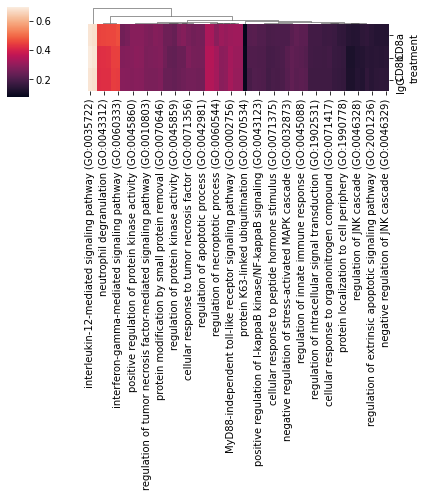

In [42]:
cDC_a_up, cDC_a_down, cDC_go_hits = alpha_specific_changes("cDC", "cDC")
adata_sub = adata_nodub[adata_nodub.obs["General Celltypes"]=="cDC"]
adata_sub.obs[["treatment",]+list(cDC_go_hits)].groupby(["treatment"]).mean().to_csv("cd8a_specific_genes_enrichment/cDC_mean_hits.csv")
pd.DataFrame(index=cDC_a_up).to_csv("cd8a_specific_genes_enrichment/cDC_CD8a_specific_genes_up.txt")
pd.DataFrame(index=cDC_a_down).to_csv("cd8a_specific_genes_enrichment/cDC_CD8a_specific_genes_down.txt")

In [18]:
cDC_a_up, cDC_a_down,GO_cDC_up,GO_cDC_down = alpha_specific_changes("cDC", "cDC",cell_score=False)

IFITM3.like..1
Mafa.B
LD5.1
NKX3.1
ERVMER34.1
ERV3.1
IFITM3.like..3
IFITM3.like..2
NKX2.1
MAFA.F
IFITM3.like..1
Mafa.B
LD5.1
NKX3.1
ERVMER34.1
ERV3.1
IFITM3.like..3
IFITM3.like..2
NKX2.1
MAFA.F
['neutrophil degranulation (GO:0043312)'
 'neutrophil activation involved in immune response (GO:0002283)'
 'neutrophil mediated immunity (GO:0002446)'
 'regulation of neutrophil degranulation (GO:0043313)'
 'regulation of stress-activated protein kinase signaling cascade (GO:0070302)']
['regulation of cytokine-mediated signaling pathway (GO:0001959)'
 'cytokine-mediated signaling pathway (GO:0019221)'
 'regulation of JNK cascade (GO:0046328)'
 'regulation of programmed necrotic cell death (GO:0062098)'
 'regulation of melanin biosynthetic process (GO:0048021)']


In [19]:
import gseapy

In [98]:
celltype="cDC"
celltype_filename = "cDC"
cd8a = pd.read_csv("tables/differential_genes/all_cells/pairwise_comparisons/"+celltype_filename+"_CD8a_vs_IgG_deseq2.csv",index_col=0)
rename_genes_R_messed_up(cd8a, adata_nodub)
cd8b = pd.read_csv("tables/differential_genes/all_cells/pairwise_comparisons/"+celltype_filename+"_CD8b_vs_IgG_deseq2.csv",index_col=0)
rename_genes_R_messed_up(cd8b, adata_nodub)
overlap_genes = list(set(cd8a.index).intersection(adata_nodub.uns["rank_genes_groups"]["pts"].index))
cd8a.loc[overlap_genes, "pts_grp1"] = adata_nodub.uns["rank_genes_groups"]["pts"].loc[overlap_genes,celltype]
min_padj=0.05
degenes = cd8a[(cd8a["padj"]<min_padj)&(cd8a["pts_grp1"] > .3)].sort_values("log2FoldChange")["log2FoldChange"]


outdir='enrichr/'

enr_a=gp.prerank(degenes, gene_sets="GO_Biological_Process_2021")
overlap_genes = list(set(cd8b.index).intersection(adata_nodub.uns["rank_genes_groups"]["pts"].index))

cd8b.loc[overlap_genes, "pts_grp1"] = adata_nodub.uns["rank_genes_groups"]["pts"].loc[overlap_genes,celltype]

degenes_b = cd8b[(cd8b["padj"]<min_padj)&(cd8b["pts_grp1"] > .3)].sort_values("log2FoldChange")["log2FoldChange"]
enr_b=gp.prerank(degenes_b, gene_sets="GO_Biological_Process_2021")


LD5.1
IFITM3.like..2
NKX3.1
NKX2.1
MAFA.F
IFITM3.like..3
Mafa.B
IFITM3.like..1
ERVMER34.1
ERV3.1
LD5.1
IFITM3.like..2
NKX3.1
NKX2.1
MAFA.F
IFITM3.like..3
Mafa.B
IFITM3.like..1
ERVMER34.1
ERV3.1


KeyboardInterrupt: 

In [110]:
celltype="cDC"
celltype_filename = "cDC"
alpha_enr, beta_enr = compare_down_alpha_beta(celltype,celltype_filename)

LD5.1
IFITM3.like..2
NKX3.1
NKX2.1
MAFA.F
IFITM3.like..3
Mafa.B
IFITM3.like..1
ERVMER34.1
ERV3.1
LD5.1
IFITM3.like..2
NKX3.1
NKX2.1
MAFA.F
IFITM3.like..3
Mafa.B
IFITM3.like..1
ERVMER34.1
ERV3.1


In [111]:

alpha_enr.res2d[(alpha_enr.res2d["Adjusted P-value"] < 0.05)&(alpha_enr.res2d["n_genes"]>4)].head(10)

alpha_enr.res2d[(alpha_enr.res2d["Adjusted P-value"] < 0.05)&(alpha_enr.res2d["n_genes"]>4)].to_csv("cd8a_specific_genes_enrichment/cDC_CD8a_v_IgG_down.txt")

In [113]:

beta_enr.res2d[(beta_enr.res2d["Adjusted P-value"] < 0.05)&(beta_enr.res2d["n_genes"]>4)].to_csv("cd8a_specific_genes_enrichment/cDC_CD8b_v_IgG_down.txt")

In [114]:
beta_enr.res2d[(beta_enr.res2d["Adjusted P-value"] < 0.05)&(beta_enr.res2d["n_genes"]>4)]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes


In [26]:
# cdc subsets
celltype_filename = "DC1"
#cdc_adata = sc.read_h5ad("cdc_subclustered.h5ad")
#sc.tl.rank_genes_groups(cdc_adata, groupby="cDC clusters",pts=True)
alpha_path= "tables/differential_genes/"+celltype_filename+"_CD8a_vs_IgG_deseq2.csv"
beta_path= "tables/differential_genes/"+celltype_filename+"_CD8b_vs_IgG_deseq2.csv"
cDC_a_up, cDC_a_down,GO_cDC_up,GO_cDC_down = alpha_specific_changes("DC1", "DC1",cell_score=False,alpha_path=alpha_path, beta_path=beta_path,adata_nodub=cdc_adata)

ERV3.1
IFITM3.like..2
LD5.1
MAFA.F
NKX3.1
Mafa.B
ERV3.1
IFITM3.like..2
LD5.1
MAFA.F
NKX3.1
Mafa.B
['neutrophil mediated immunity (GO:0002446)'
 'neutrophil degranulation (GO:0043312)'
 'neutrophil activation involved in immune response (GO:0002283)'
 'macrophage activation (GO:0042116)'
 'regulation of interleukin-6 production (GO:0032675)']
['regulation of cytokine-mediated signaling pathway (GO:0001959)'
 'cytokine-mediated signaling pathway (GO:0019221)'
 'microvillus organization (GO:0032528)'
 'response to cytokine (GO:0034097)' 'microvillus assembly (GO:0030033)']


In [27]:
GO_cDC_up.res2d[(GO_cDC_up.res2d["n_genes"]>4)&(GO_cDC_up.res2d["Adjusted P-value"]<0.05)].to_csv("tables/differential_genes/cDC1_GO_up_alpha_specific.csv")
GO_cDC_down.res2d[(GO_cDC_down.res2d["n_genes"]>4)&(GO_cDC_down.res2d["Adjusted P-value"]<0.05)].to_csv("tables/differential_genes/cDC1_GO_down_alpha_specific.csv")

In [23]:
celltype_filename = "DC2"

alpha_path= "tables/differential_genes/"+celltype_filename+"_CD8a_vs_IgG_deseq2.csv"
beta_path= "tables/differential_genes/"+celltype_filename+"_CD8b_vs_IgG_deseq2.csv"
cDC_a_up, cDC_a_down,GO_cDC_up,GO_cDC_down = alpha_specific_changes("DC2", "DC2",cell_score=False,alpha_path=alpha_path, beta_path=beta_path,adata_nodub=cdc_adata)

ERV3.1
IFITM3.like..2
LD5.1
MAFA.F
NKX3.1
Mafa.B
ERV3.1
IFITM3.like..2
LD5.1
MAFA.F
NKX3.1
Mafa.B
['regulation of sterol transport (GO:0032371)'
 'negative regulation of B cell receptor signaling pathway (GO:0050859)'
 'regulation of B cell receptor signaling pathway (GO:0050855)'
 'negative regulation of antigen receptor-mediated signaling pathway (GO:0050858)'
 'regulation of cholesterol transport (GO:0032374)']
['positive regulation of Rho protein signal transduction (GO:0035025)'
 'positive regulation of Ras protein signal transduction (GO:0046579)'
 'regulation of Rho protein signal transduction (GO:0035023)'
 'regulation of protein localization to cell cortex (GO:1904776)'
 'positive regulation of dendritic cell cytokine production (GO:0002732)']


In [24]:
gseapy.dotplot(GO_cDC_up.res2d[GO_cDC_up.res2d["n_genes"]>4])

'Warning: No enrich terms when cutoff = 0.05'

In [25]:
gseapy.dotplot(GO_cDC_down.res2d[GO_cDC_down.res2d["n_genes"]>4])

'Warning: No enrich terms when cutoff = 0.05'

In [58]:
cdc_GO_hits = ["regulation of interleukin-1 beta production (GO:0032651)","positive regulation of interleukin-6 production (GO:0032755)",
              "positive regulation of NF-kappaB transcription factor activity (GO:0051092)","regulation of interleukin-6 production (GO:0032675)",]
score_go_hits(cdc_GO_hits, genelist_references,  cdc_adata, gene_set="GO_Biological_Process_2021")

regulation of interleukin-1 beta production (GO:0032651)


positive regulation of interleukin-6 production (GO:0032755)


positive regulation of NF-kappaB transcription factor activity (GO:0051092)


regulation of interleukin-6 production (GO:0032675)


['regulation of interleukin-1 beta production (GO:0032651)',
 'positive regulation of interleukin-6 production (GO:0032755)',
 'positive regulation of NF-kappaB transcription factor activity (GO:0051092)',
 'regulation of interleukin-6 production (GO:0032675)']

In [59]:
cdc_adata.obs["clusts_dep"] = cdc_adata.obs["cDC clusters"].astype(str) + cdc_adata.obs["treatment"].astype(str)

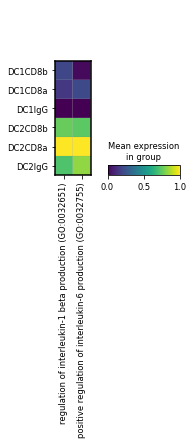

In [70]:
cdc_GO_hits = ["regulation of interleukin-1 beta production (GO:0032651)","positive regulation of interleukin-6 production (GO:0032755)"]
sc.pl.matrixplot(cdc_adata, cdc_GO_hits, groupby="clusts_dep",standard_scale="var",
                 categories_order = ['DC1CD8b',  'DC1CD8a','DC1IgG','DC2CD8b',  'DC2CD8a','DC2IgG'],show=False)
plt.savefig("cdc_subcluster_GO_scores.pdf",bbox_inches="tight")

In [143]:
import scipy.stats
for f in cdc_GO_hits:
    for c in cdc_adata.obs["cDC clusters"].unique():
        macsub = cdc_adata[cdc_adata.obs["cDC clusters"]==c]
        
        print(c + " " + f)
        print(scipy.stats.mannwhitneyu(macsub.obs.loc[macsub.obs["treatment"]=="IgG",f],macsub.obs.loc[macsub.obs["treatment"]=="CD8a",f],alternative="less"))

DC1 regulation of interleukin-1 beta production (GO:0032651)
MannwhitneyuResult(statistic=28799.0, pvalue=0.00164338541766827)
DC2 regulation of interleukin-1 beta production (GO:0032651)
MannwhitneyuResult(statistic=18258.0, pvalue=1.7744605627536678e-05)
DC1 positive regulation of interleukin-6 production (GO:0032755)
MannwhitneyuResult(statistic=25153.0, pvalue=2.2191833723894452e-07)
DC2 positive regulation of interleukin-6 production (GO:0032755)
MannwhitneyuResult(statistic=19332.0, pvalue=0.00043767344581202556)


In [127]:
celltype="Macrophages/Monocytes"
celltype_filename = 'Macrophages_Monocytes'
alpha_enr, beta_enr = compare_down_alpha_beta(celltype,celltype_filename)

LD5.1
IFITM3.like..2
NKX3.1
NKX2.1
MAFA.F
IFITM3.like..3
Mafa.B
IFITM3.like..1
ERVMER34.1
ERV3.1
LD5.1
IFITM3.like..2
NKX3.1
NKX2.1
MAFA.F
IFITM3.like..3
Mafa.B
IFITM3.like..1
ERVMER34.1
ERV3.1


In [128]:
alpha_enr.res2d[(alpha_enr.res2d["Adjusted P-value"] < 0.05)&(alpha_enr.res2d["n_genes"]>4)].head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes
0,GO_Biological_Process_2021,cytoplasmic translation (GO:0002181),8/93,0.000002,0.003458,0,0,10.551337,136.965279,RPL34;RPLP1;RPL27A;RPL38;RPL22L1;RPL37;RPS27A;...,8
1,GO_Biological_Process_2021,SRP-dependent cotranslational protein targetin...,7/90,0.000020,0.012984,0,0,9.402423,101.952649,RPL34;RPLP1;RPL27A;RPL38;RPL37;RPS27A;RPS12,7
2,GO_Biological_Process_2021,cotranslational protein targeting to membrane ...,7/94,0.000026,0.012984,0,0,8.968310,94.698929,RPL34;RPLP1;RPL27A;RPL38;RPL37;RPS27A;RPS12,7
3,GO_Biological_Process_2021,protein targeting to ER (GO:0045047),7/103,0.000047,0.017586,0,0,8.123823,80.980186,RPL34;RPL27A;RPLP1;RPL38;RPL37;RPS27A;RPS12,7
4,GO_Biological_Process_2021,"nuclear-transcribed mRNA catabolic process, no...",7/113,0.000085,0.025389,0,0,7.353694,68.962055,RPL34;RPL27A;RPLP1;RPL38;RPL37;RPS27A;RPS12,7


In [129]:
alpha_enr.res2d[(alpha_enr.res2d["Adjusted P-value"] < 0.05)&(alpha_enr.res2d["n_genes"]>4)].to_csv("cd8a_specific_genes_enrichment/Macrophages_Monocytes_CD8a_v_IgG_down_GO.csv")

In [130]:
beta_enr.res2d[beta_enr.res2d["Adjusted P-value"] < 0.05]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes
0,GO_Biological_Process_2021,positive regulation of chemokine production (G...,4/53,0.000004,0.001216,0,0,45.149660,564.192101,OAS3;IL18;HMOX1;MBP,4
1,GO_Biological_Process_2021,negative regulation of viral genome replicatio...,3/54,0.000171,0.015019,0,0,31.651828,274.493830,IFIH1;OAS3;APOBEC3A,3
2,GO_Biological_Process_2021,cytoplasmic pattern recognition receptor signa...,2/10,0.000174,0.015019,0,0,131.263158,1136.475641,IFIH1;OAS3,2
3,GO_Biological_Process_2021,cellular iron ion homeostasis (GO:0006879),3/58,0.000212,0.015019,0,0,29.343980,248.235427,FRRS1;HMOX1;ACO1,3
4,GO_Biological_Process_2021,iron ion homeostasis (GO:0055072),3/61,0.000246,0.015019,0,0,27.821994,231.193630,FRRS1;HMOX1;ACO1,3
5,GO_Biological_Process_2021,regulation of chemokine (C-X-C motif) ligand 2...,2/13,0.000300,0.015019,0,0,95.449761,774.263839,OAS3;MBP,2
6,GO_Biological_Process_2021,regulation of viral genome replication (GO:004...,3/67,0.000325,0.015019,0,0,25.206081,202.456936,IFIH1;OAS3;APOBEC3A,3
7,GO_Biological_Process_2021,negative regulation of viral process (GO:0048525),3/70,0.000370,0.015019,0,0,24.073820,190.251615,IFIH1;OAS3;APOBEC3A,3
8,GO_Biological_Process_2021,cellular transition metal ion homeostasis (GO:...,3/96,0.000931,0.033615,0,0,17.320837,120.888620,FRRS1;HMOX1;ACO1,3
9,GO_Biological_Process_2021,regulation of interleukin-6 production (GO:003...,3/110,0.001379,0.044823,0,0,15.043950,99.083496,IFIH1;SYT11;MBP,3


In [131]:
beta_enr.res2d[(beta_enr.res2d["Adjusted P-value"] < 0.05)&(beta_enr.res2d["n_genes"]>4)].to_csv("cd8a_specific_genes_enrichment/Macrophages_Monocytes_CD8b_v_IgG_down_GO.csv")

In [30]:
# mac subsets
celltype_filename = "Monocyte"
#mac_adata= sc.read_h5ad("cd8_depletion_code/Analysis/preprocessing/mono_mac_harmony_integrated.h5ad")
#sc.tl.rank_genes_groups(mac_adata, groupby="mac_clusts",pts=True)
alpha_path= "tables/differential_genes/"+celltype_filename+"_CD8a_vs_IgG_deseq2.csv"
beta_path= "tables/differential_genes/"+celltype_filename+"_CD8b_vs_IgG_deseq2.csv"
cDC_a_up, cDC_a_down,GO_cDC_up,GO_cDC_down = alpha_specific_changes("Monocyte", "Monocyte",cell_score=False,alpha_path=alpha_path, beta_path=beta_path,adata_nodub=mac_adata)

ERV3.1
IFITM3.like..1
ERVMER34.1
IFITM3.like..2
LD5.1
MAFA.F
NKX6.1
NKX3.1
Mafa.B
IFITM3.like..3
ERV3.1
IFITM3.like..1
ERVMER34.1
IFITM3.like..2
LD5.1
MAFA.F
NKX6.1
NKX3.1
Mafa.B
IFITM3.like..3
['neutrophil mediated immunity (GO:0002446)'
 'neutrophil degranulation (GO:0043312)'
 'neutrophil activation involved in immune response (GO:0002283)'
 'cytokine-mediated signaling pathway (GO:0019221)'
 'positive regulation of interleukin-1 beta production (GO:0032731)']
['regulation of mRNA splicing, via spliceosome (GO:0048024)'
 'regulation of mRNA processing (GO:0050684)'
 'positive regulation of transcription by RNA polymerase II (GO:0045944)'
 'regulation of protein localization to Cajal body (GO:1904869)'
 'positive regulation of protein localization to Cajal body (GO:1904871)']


In [33]:
GO_cDC_up.res2d[(GO_cDC_up.res2d["n_genes"]>4)&(GO_cDC_up.res2d["Adjusted P-value"]<0.05)].to_csv("tables/differential_genes/Monocytes_GO_up_alpha_specific.csv")
GO_cDC_down.res2d[(GO_cDC_down.res2d["n_genes"]>4)&(GO_cDC_down.res2d["Adjusted P-value"]<0.05)].to_csv("tables/differential_genes/Monocytes_GO_down_alpha_specific.csv")

In [49]:
mac_GO_hits = ["type I interferon signaling pathway (GO:0060337)","interleukin-1-mediated signaling pathway (GO:0070498)","cellular response to interleukin-1 (GO:0071347)",
              "positive regulation of NF-kappaB transcription factor activity (GO:0051092)","regulation of interleukin-6 production (GO:0032675)",
              "type I interferon signaling pathway (GO:0060337)"]
score_go_hits(mac_GO_hits, genelist_references,  mac_adata, gene_set="GO_Biological_Process_2021")

interleukin-1-mediated signaling pathway (GO:0070498)


cellular response to interleukin-1 (GO:0071347)


positive regulation of NF-kappaB transcription factor activity (GO:0051092)


regulation of interleukin-6 production (GO:0032675)


type I interferon signaling pathway (GO:0060337)


['interleukin-1-mediated signaling pathway (GO:0070498)',
 'cellular response to interleukin-1 (GO:0071347)',
 'positive regulation of NF-kappaB transcription factor activity (GO:0051092)',
 'regulation of interleukin-6 production (GO:0032675)',
 'type I interferon signaling pathway (GO:0060337)']

In [52]:
mac_adata.obs["clusts_dep"] = mac_adata.obs["mac_clusts"].astype(str) + mac_adata.obs["treatment"].astype(str)

In [55]:
mac_adata.obs["clusts_dep"].cat.categories

Index(['Alv.MacCD8a', 'Alv.MacCD8b', 'Alv.MacIgG', 'Inflam.MacCD8a',
       'Inflam.MacCD8b', 'Inflam.MacIgG', 'MacCD8a', 'MacCD8b', 'MacIgG',
       'MonocyteCD8a', 'MonocyteCD8b', 'MonocyteIgG'],
      dtype='object')

{'mainplot_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

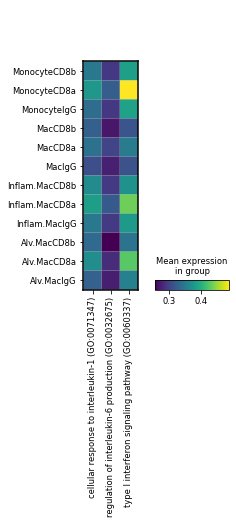

In [75]:
mac_GO_hits = ["cellular response to interleukin-1 (GO:0071347)",
              "regulation of interleukin-6 production (GO:0032675)",
              "type I interferon signaling pathway (GO:0060337)"]
sc.pl.matrixplot(mac_adata, mac_GO_hits, groupby="clusts_dep",standard_scale="var",
                 categories_order = ['MonocyteCD8b', 'MonocyteCD8a','MonocyteIgG',
                                     'MacCD8b',  'MacCD8a','MacIgG',
                                      'Inflam.MacCD8b', 'Inflam.MacCD8a','Inflam.MacIgG',
       'Alv.MacCD8b',  'Alv.MacCD8a','Alv.MacIgG'  ],show=False)
#plt.savefig("mac_subcluster_GO_scores.pdf",bbox_inches="tight")

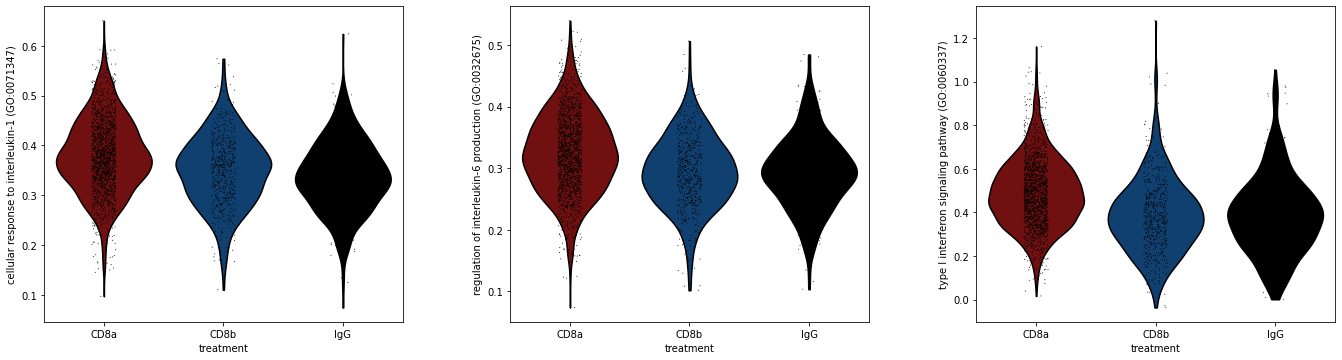

In [92]:
sc.pl.violin(mac_adata[mac_adata.obs["mac_clusts"]=="Monocyte"],mac_GO_hits,groupby="treatment")

In [49]:
mac_GO_hits = ["interleukin-1-mediated signaling pathway (GO:0070498)","cellular response to interleukin-1 (GO:0071347)",
              "positive regulation of NF-kappaB transcription factor activity (GO:0051092)","regulation of interleukin-6 production (GO:0032675)",
              "type I interferon signaling pathway (GO:0060337)"]
score_go_hits(mac_GO_hits, genelist_references,  mac_adata, gene_set="GO_Biological_Process_2021")

interleukin-1-mediated signaling pathway (GO:0070498)


cellular response to interleukin-1 (GO:0071347)


positive regulation of NF-kappaB transcription factor activity (GO:0051092)


regulation of interleukin-6 production (GO:0032675)


type I interferon signaling pathway (GO:0060337)


['interleukin-1-mediated signaling pathway (GO:0070498)',
 'cellular response to interleukin-1 (GO:0071347)',
 'positive regulation of NF-kappaB transcription factor activity (GO:0051092)',
 'regulation of interleukin-6 production (GO:0032675)',
 'type I interferon signaling pathway (GO:0060337)']

In [52]:
mac_adata.obs["clusts_dep"] = mac_adata.obs["mac_clusts"].astype(str) + mac_adata.obs["treatment"].astype(str)

In [55]:
mac_adata.obs["clusts_dep"].cat.categories

Index(['Alv.MacCD8a', 'Alv.MacCD8b', 'Alv.MacIgG', 'Inflam.MacCD8a',
       'Inflam.MacCD8b', 'Inflam.MacIgG', 'MacCD8a', 'MacCD8b', 'MacIgG',
       'MonocyteCD8a', 'MonocyteCD8b', 'MonocyteIgG'],
      dtype='object')

{'mainplot_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

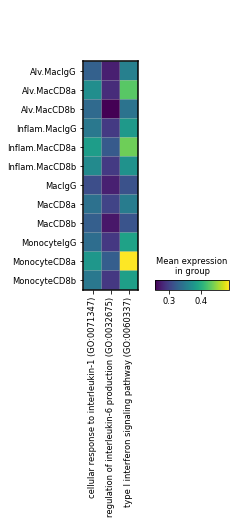

In [94]:
mac_GO_hits = ["cellular response to interleukin-1 (GO:0071347)",
              "regulation of interleukin-6 production (GO:0032675)",
              "type I interferon signaling pathway (GO:0060337)"]
sc.pl.matrixplot(mac_adata, mac_GO_hits, groupby="clusts_dep",standard_scale="var",
                 categories_order = ['Alv.MacIgG','Alv.MacCD8a',  'Alv.MacCD8b','Inflam.MacIgG', 'Inflam.MacCD8a', 
       'Inflam.MacCD8b', 'MacIgG','MacCD8a',  'MacCD8b', 'MonocyteIgG',
       'MonocyteCD8a', 'MonocyteCD8b'],show=False)
#plt.savefig("mac_subcluster_GO_scores.pdf",bbox_inches="tight")

In [ ]:
for f in mac_GO_hits:
    for c in mac_adata.obs["mac_clusts"].unique():
        macsub = mac_adata[mac_adata.obs["mac_clusts"]==c]
        plt.figure()
        sample_means = macsub.obs.groupby(["treatment","sample"])[f].mean().reset_index()
        sns.boxplot(data=sample_means[sample_means[f].notna()],x="treatment",y=f)
        sns.stripplot(data=sample_means[sample_means[f].notna()],x="treatment",y=f)
        print(c + " " + f)
        print(scipy.stats.ttest_ind(list(sample_means.loc[(sample_means["treatment"] =="IgG")&(sample_means[f].notna()),f].values),list(sample_means.loc[(sample_means["treatment"] =="CD8a")&(sample_means[f].notna()),f].values)))

In [141]:
import scipy.stats
for f in mac_GO_hits:
    for c in mac_adata.obs["mac_clusts"].unique():
        macsub = mac_adata[mac_adata.obs["mac_clusts"]==c]
        
        print(c + " " + f)
        print(scipy.stats.mannwhitneyu(macsub.obs.loc[macsub.obs["treatment"]=="IgG",f],macsub.obs.loc[macsub.obs["treatment"]=="CD8a",f],alternative="less"))

Mac cellular response to interleukin-1 (GO:0071347)
MannwhitneyuResult(statistic=2680265.5, pvalue=2.0898778779401263e-70)
Alv.Mac cellular response to interleukin-1 (GO:0071347)
MannwhitneyuResult(statistic=68775.0, pvalue=1.1312044168346366e-20)
Monocyte cellular response to interleukin-1 (GO:0071347)
MannwhitneyuResult(statistic=279487.0, pvalue=3.816101146541075e-24)
Inflam.Mac cellular response to interleukin-1 (GO:0071347)
MannwhitneyuResult(statistic=820622.0, pvalue=7.044248414207012e-42)
Mac regulation of interleukin-6 production (GO:0032675)
MannwhitneyuResult(statistic=2711041.5, pvalue=1.3370234855224638e-66)
Alv.Mac regulation of interleukin-6 production (GO:0032675)
MannwhitneyuResult(statistic=102432.0, pvalue=0.012120530862790179)
Monocyte regulation of interleukin-6 production (GO:0032675)
MannwhitneyuResult(statistic=292429.0, pvalue=8.438449643692254e-20)
Inflam.Mac regulation of interleukin-6 production (GO:0032675)
MannwhitneyuResult(statistic=887812.0, pvalue=7.15

In [131]:
list(sample_means.loc[(sample_means["treatment"] =="IgG")&(sample_means[f].notna()),f].values)

[0.3602779,
 0.45031688,
 0.5805814,
 0.3246634,
 0.3397414,
 0.4334035,
 0.29856446,
 0.45033693,
 0.30411637,
 0.35641354,
 0.29219887,
 0.38670883]

In [134]:
list(sample_means.loc[(sample_means["treatment"] =="CD8a")&(sample_means[f].notna()),f].values)

[0.46152303,
 0.5121758,
 0.50641733,
 0.415109,
 0.40423948,
 0.4242072,
 0.4576212,
 0.50762373,
 0.40530887,
 0.46419677,
 0.57314914,
 0.4256922,
 0.40385187,
 0.3920552,
 0.4019831,
 0.45576575,
 0.37393397]

<AxesSubplot:xlabel='treatment', ylabel='type I interferon signaling pathway (GO:0060337)'>

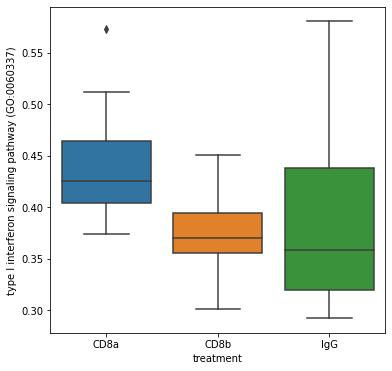

In [123]:
import seaborn as sns
sns.boxplot(data=sample_means[sample_means[f].notna()],x="treatment",y=f)

In [118]:
sample_means=macsub.obs.groupby(["treatment","sample"])[f].mean().reset_index()

In [107]:
scipy.stats.mannwhitneyu(list(macsub.obs.loc[macsub.obs["treatment"]=="IgG",f].values),list(macsub.obs.loc[macsub.obs["treatment"]=="CD8A",f].values),alternative="less")

MannwhitneyuResult(statistic=0.0, pvalue=1.0)

In [102]:
scipy.stats.ttest_ind(cdc_adata.obs.loc[cdc_adata.obs["cDC clusters"]=="DC1","regulation of interleukin-1 beta production (GO:0032651)"],cdc_adata.obs.loc[cdc_adata.obs["cDC clusters"]=="DC2","regulation of interleukin-1 beta production (GO:0032651)"])#,alternative="two-sided")

Ttest_indResult(statistic=-22.3667612205676, pvalue=9.402984537262564e-96)

/afs/csail.mit.edu/u/n/nyquist/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

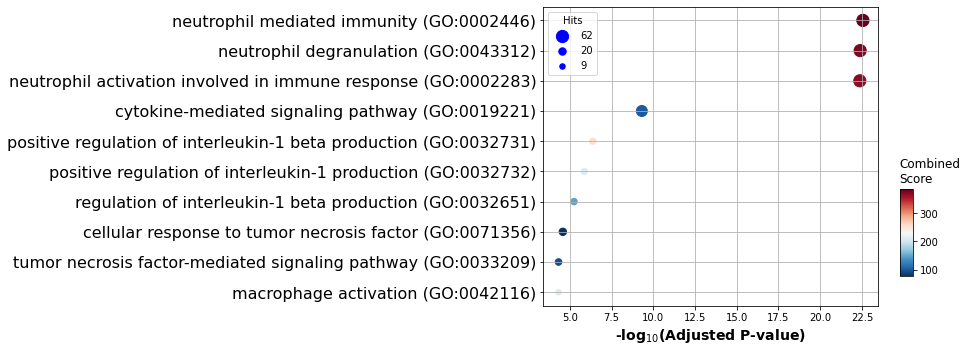

In [31]:
import gseapy
gseapy.dotplot(GO_cDC_up.res2d[GO_cDC_up.res2d["n_genes"]>4])

/afs/csail.mit.edu/u/n/nyquist/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

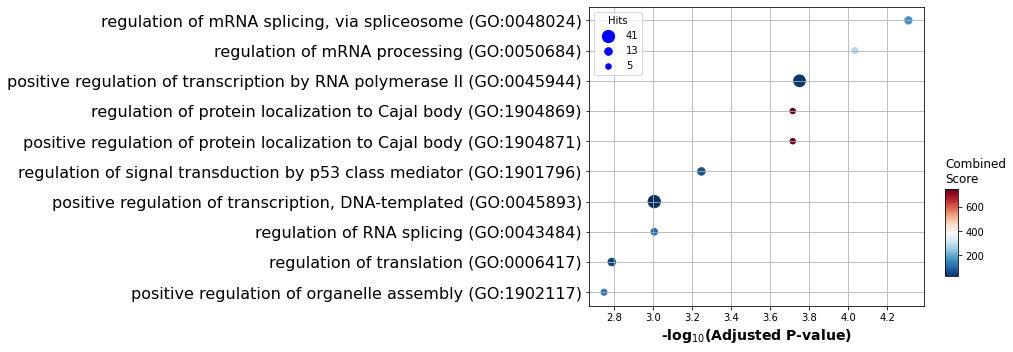

In [32]:
gseapy.dotplot(GO_cDC_down.res2d[GO_cDC_down.res2d["n_genes"]>4])

In [35]:
# mac subsets
celltype_filename = "Inflam.Mac"
#mac_adata= sc.read_h5ad("cd8_depletion_code/Analysis/preprocessing/mono_mac_harmony_integrated.h5ad")
#sc.tl.rank_genes_groups(mac_adata, groupby="mac_clusts",pts=True)
alpha_path= "tables/differential_genes/"+celltype_filename+"_CD8a_vs_IgG_deseq2.csv"
beta_path= "tables/differential_genes/"+celltype_filename+"_CD8b_vs_IgG_deseq2.csv"
cDC_a_up, cDC_a_down,GO_cDC_up,GO_cDC_down = alpha_specific_changes(celltype_filename, celltype_filename,cell_score=False,alpha_path=alpha_path, beta_path=beta_path,adata_nodub=mac_adata)

ERV3.1
IFITM3.like..1
ERVMER34.1
IFITM3.like..2
LD5.1
MAFA.F
NKX6.1
NKX3.1
Mafa.B
IFITM3.like..3
ERV3.1
IFITM3.like..1
ERVMER34.1
IFITM3.like..2
LD5.1
MAFA.F
NKX6.1
NKX3.1
Mafa.B
IFITM3.like..3
['cytokine-mediated signaling pathway (GO:0019221)'
 'neutrophil mediated immunity (GO:0002446)'
 'neutrophil degranulation (GO:0043312)'
 'neutrophil activation involved in immune response (GO:0002283)'
 'interleukin-1-mediated signaling pathway (GO:0070498)']
['actin polymerization or depolymerization (GO:0008154)'
 'regulation of JNK cascade (GO:0046328)'
 'cellular response to thyroid hormone stimulus (GO:0097067)'
 'response to thyroid hormone (GO:0097066)'
 'negative regulation of JNK cascade (GO:0046329)']


In [39]:
GO_cDC_up.res2d[(GO_cDC_up.res2d["n_genes"]>4)&(GO_cDC_up.res2d["Adjusted P-value"]<0.05)].to_csv("tables/differential_genes/"+celltype_filename+"_GO_up_alpha_specific.csv")
GO_cDC_down.res2d[(GO_cDC_down.res2d["n_genes"]>4)&(GO_cDC_down.res2d["Adjusted P-value"]<0.05)].to_csv("tables/differential_genes/"+celltype_filename+"_GO_down_alpha_specific.csv")

/afs/csail.mit.edu/u/n/nyquist/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

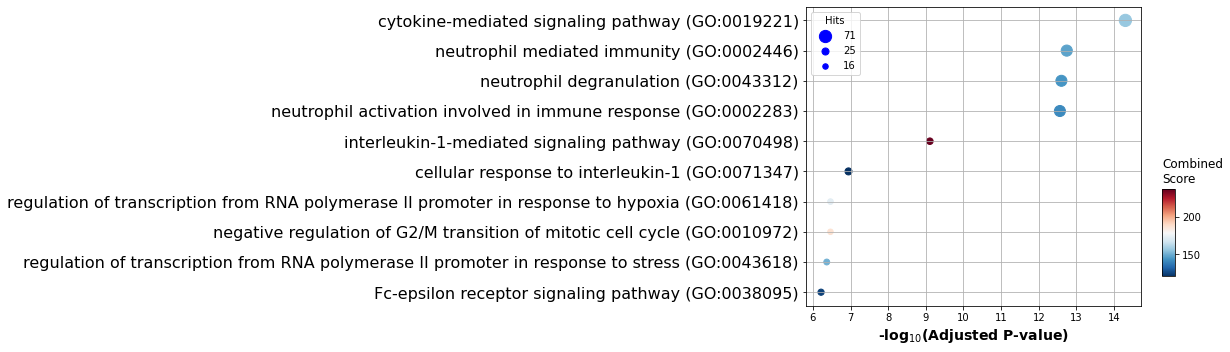

In [36]:
import gseapy
gseapy.dotplot(GO_cDC_up.res2d[GO_cDC_up.res2d["n_genes"]>4])

/afs/csail.mit.edu/u/n/nyquist/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

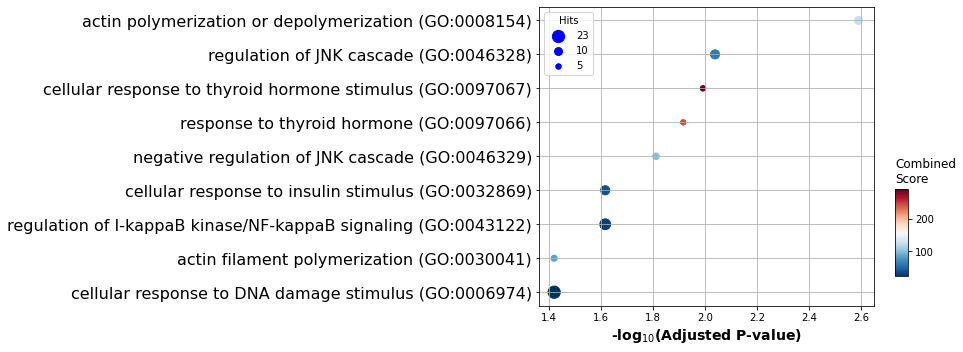

In [37]:
gseapy.dotplot(GO_cDC_down.res2d[GO_cDC_down.res2d["n_genes"]>4])

In [40]:
# mac subsets
celltype_filename = "Alv.Mac"
#mac_adata= sc.read_h5ad("cd8_depletion_code/Analysis/preprocessing/mono_mac_harmony_integrated.h5ad")
#sc.tl.rank_genes_groups(mac_adata, groupby="mac_clusts",pts=True)
alpha_path= "tables/differential_genes/"+celltype_filename+"_CD8a_vs_IgG_deseq2.csv"
beta_path= "tables/differential_genes/"+celltype_filename+"_CD8b_vs_IgG_deseq2.csv"
cDC_a_up, cDC_a_down,GO_cDC_up,GO_cDC_down = alpha_specific_changes(celltype_filename, celltype_filename,cell_score=False,alpha_path=alpha_path, beta_path=beta_path,adata_nodub=mac_adata)

ERV3.1
IFITM3.like..1
ERVMER34.1
IFITM3.like..2
LD5.1
MAFA.F
NKX6.1
NKX3.1
Mafa.B
IFITM3.like..3
ERV3.1
IFITM3.like..1
ERVMER34.1
IFITM3.like..2
LD5.1
MAFA.F
NKX6.1
NKX3.1
Mafa.B
IFITM3.like..3
['ATF6-mediated unfolded protein response (GO:0036500)'
 'neutrophil degranulation (GO:0043312)'
 'neutrophil activation involved in immune response (GO:0002283)'
 'neutrophil mediated immunity (GO:0002446)'
 'positive regulation of steroid biosynthetic process (GO:0010893)']
['regulation of innate immune response (GO:0045088)'
 'regulation of protein deubiquitination (GO:0090085)'
 'positive regulation of membrane invagination (GO:1905155)'
 'positive regulation of phagocytosis, engulfment (GO:0060100)'
 'negative regulation of intracellular signal transduction (GO:1902532)']


In [43]:
GO_cDC_up.res2d[(GO_cDC_up.res2d["n_genes"]>4)&(GO_cDC_up.res2d["Adjusted P-value"]<0.05)].to_csv("tables/differential_genes/"+celltype_filename+"_GO_up_alpha_specific.csv")
GO_cDC_down.res2d[(GO_cDC_down.res2d["n_genes"]>4)&(GO_cDC_down.res2d["Adjusted P-value"]<0.05)].to_csv("tables/differential_genes/"+celltype_filename+"_GO_down_alpha_specific.csv")

/afs/csail.mit.edu/u/n/nyquist/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

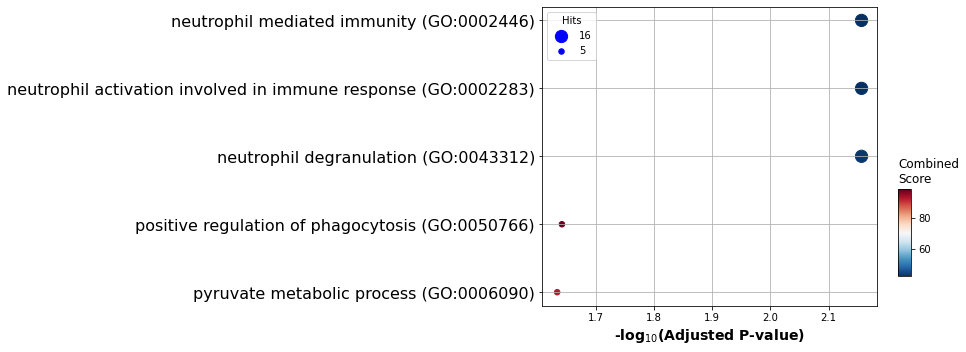

In [41]:
import gseapy
gseapy.dotplot(GO_cDC_up.res2d[GO_cDC_up.res2d["n_genes"]>4])

/afs/csail.mit.edu/u/n/nyquist/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

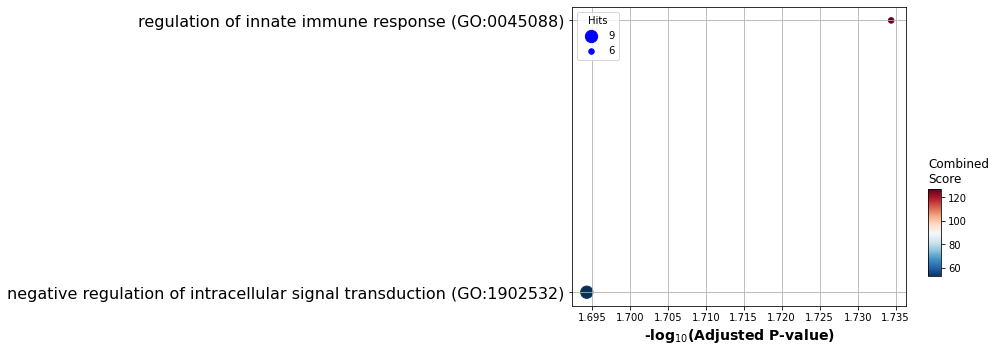

In [42]:
gseapy.dotplot(GO_cDC_down.res2d[GO_cDC_down.res2d["n_genes"]>4])

In [44]:
# mac subsets
celltype_filename = "Mac"
#mac_adata= sc.read_h5ad("cd8_depletion_code/Analysis/preprocessing/mono_mac_harmony_integrated.h5ad")
#sc.tl.rank_genes_groups(mac_adata, groupby="mac_clusts",pts=True)
alpha_path= "tables/differential_genes/"+celltype_filename+"_CD8a_vs_IgG_deseq2.csv"
beta_path= "tables/differential_genes/"+celltype_filename+"_CD8b_vs_IgG_deseq2.csv"
cDC_a_up, cDC_a_down,GO_cDC_up,GO_cDC_down = alpha_specific_changes(celltype_filename, celltype_filename,cell_score=False,alpha_path=alpha_path, beta_path=beta_path,adata_nodub=mac_adata)

ERV3.1
IFITM3.like..1
ERVMER34.1
IFITM3.like..2
LD5.1
MAFA.F
NKX6.1
NKX3.1
Mafa.B
IFITM3.like..3
ERV3.1
IFITM3.like..1
ERVMER34.1
IFITM3.like..2
LD5.1
MAFA.F
NKX6.1
NKX3.1
Mafa.B
IFITM3.like..3
['neutrophil mediated immunity (GO:0002446)'
 'neutrophil degranulation (GO:0043312)'
 'neutrophil activation involved in immune response (GO:0002283)'
 'cytokine-mediated signaling pathway (GO:0019221)'
 'cellular response to cytokine stimulus (GO:0071345)']
['polyamine biosynthetic process (GO:0006596)'
 'regulation of translational initiation (GO:0006446)'
 'negative regulation of intracellular signal transduction (GO:1902532)'
 'regulation of defense response to virus (GO:0050688)'
 'negative regulation of transcription by RNA polymerase II (GO:0000122)']


In [38]:
GO_cDC_up.res2d[(GO_cDC_up.res2d["n_genes"]>4)&(GO_cDC_up.res2d["Adjusted P-value"]<0.05)].to_csv("tables/differential_genes/"+celltype_filename+"_GO_up_alpha_specific.csv")
GO_cDC_down.res2d[(GO_cDC_down.res2d["n_genes"]>4)&(GO_cDC_down.res2d["Adjusted P-value"]<0.05)].to_csv("tables/differential_genes/"+celltype_filename+"_GO_down_alpha_specific.csv")

/afs/csail.mit.edu/u/n/nyquist/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

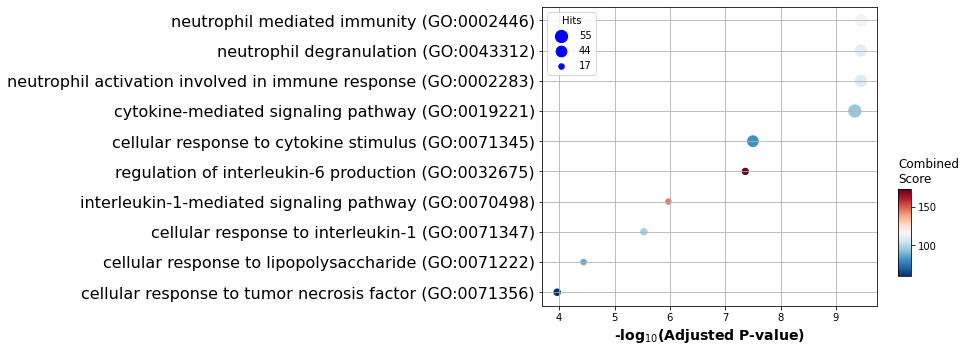

In [45]:
import gseapy
gseapy.dotplot(GO_cDC_up.res2d[GO_cDC_up.res2d["n_genes"]>4])

/afs/csail.mit.edu/u/n/nyquist/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

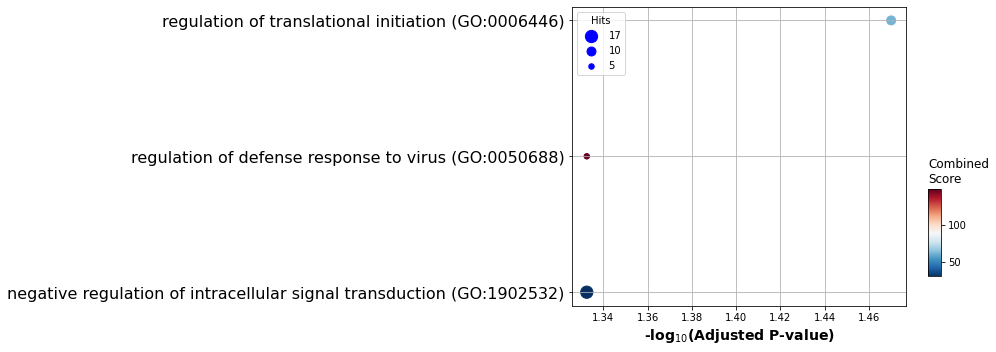

In [46]:
gseapy.dotplot(GO_cDC_down.res2d[GO_cDC_down.res2d["n_genes"]>4])

In [118]:
celltype="Mast"
celltype_filename = 'Mast'
alpha_enr, beta_enr = compare_down_alpha_beta(celltype,celltype_filename)

LD5.1
IFITM3.like..2
NKX3.1
NKX2.1
MAFA.F
IFITM3.like..3
Mafa.B
IFITM3.like..1
ERVMER34.1
ERV3.1
LD5.1
IFITM3.like..2
NKX3.1
NKX2.1
MAFA.F
IFITM3.like..3
Mafa.B
IFITM3.like..1
ERVMER34.1
ERV3.1


2023-07-12 19:02:34,628 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


In [119]:
alpha_enr.res2d[(alpha_enr.res2d["Adjusted P-value"] < 0.05)&(alpha_enr.res2d["n_genes"]>4)]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes


In [121]:
beta_enr.res2d[(beta_enr.res2d["Adjusted P-value"] < 0.05)&(beta_enr.res2d["n_genes"]>4)]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes


In [124]:
celltype="B Cells"
celltype_filename = 'B Cells'
alpha_enr, beta_enr = compare_down_alpha_beta(celltype,celltype_filename)

LD5.1
IFITM3.like..2
NKX3.1
NKX2.1
MAFA.F
IFITM3.like..3
Mafa.B
IFITM3.like..1
ERVMER34.1
ERV3.1
LD5.1
IFITM3.like..2
NKX3.1
NKX2.1
MAFA.F
IFITM3.like..3
Mafa.B
IFITM3.like..1
ERVMER34.1
ERV3.1


2023-07-12 19:04:57,371 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05
2023-07-12 19:04:58,845 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


In [125]:
alpha_enr.res2d[(alpha_enr.res2d["Adjusted P-value"] < 0.05)&(alpha_enr.res2d["n_genes"]>4)]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes


In [126]:
beta_enr.res2d[(beta_enr.res2d["Adjusted P-value"] < 0.05)&(beta_enr.res2d["n_genes"]>4)]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes


In [45]:
GO_cDC_up.res2d.loc[GO_cDC_up.res2d["Term"] =='cytokine-mediated signaling pathway (GO:0019221)',"Genes"].values[0]

'CAMK2D;SPI1;PSMD11;ITGAM;ITGB2;IL16;CBL;PSMB8;PSMB9;PYCARD;CCND1;CSNK2B;ITGAX;LTBR;MYD88'

In [46]:
GO_cDC_down.res2d.loc[GO_cDC_down.res2d["Term"] =='cytokine-mediated signaling pathway (GO:0019221)',"Genes"].values[0]

'RALA;CD40;CD80;CSF2RB;FOXO1;TRIM8;UGCG;GBP2;JAK2;PAK2;APPL1;JAK1;IL10RB;IFNGR2;IFNLR1;TRAF1;NFKB1;ISG20;ZEB1;TRAF3;PELI1;PDCD4;IL6ST;IL7R;BIRC2;BIRC3'

In [39]:
GO_cDC_up.res2d.loc[GO_cDC_up.res2d["Term"] =="neutrophil degranulation (GO:0043312)","Genes"].values[0]

'GSDMD;PSMD11;ITGAM;RNASET2;GSTP1;ATP6AP2;ITGB2;IGF2R;CPPED1;PYCARD;CST3;FTH1;CSNK2B;ITGAX;CPNE3;CD33'

In [41]:
moma_GO_up.res2d.loc[moma_GO_up.res2d["Term"] =="neutrophil degranulation (GO:0043312)","Genes"].values[0]

'CYFIP1;ITGAM;TMEM179B;SLC44A2;GMFG;TCIRG1;ITGAL;FCAR;PYCARD;HK3;LAMP1;ADGRE5;PSMD3;C3AR1;PSMD1;OLR1;QSOX1;CD36;ACAA1;GYG1;CD53;SERPINB1;FCER1G;NHLRC3;ANXA2;DGAT1;CD300A;SLC11A1;PLAUR;NDUFC2;ADAM10;MCEMP1;TNFRSF1B;DDOST;OSCAR;FGR;DOK3;PECAM1;DOCK2;S100A8;TMEM63A;PSMD14;CLEC12A;MVP;STXBP2;C5AR1;RETN;AGPAT2;TRPM2;NCSTN;ALOX5;RAB24;LTA4H;AGA;CD55;GSDMD;RAB4B;TRAPPC1;TMEM30A;STK11IP;MAPK14;IGF2R;GALNS;PFKL;TSPAN14;FCGR2A;IMPDH1;PTPN6'

In [47]:
moma_GO_up.res2d.loc[moma_GO_up.res2d["Term"] =='cytokine-mediated signaling pathway (GO:0019221)',"Genes"].values[0]

'SPI1;ITGAM;CXCL8;F13A1;SLA;IL1RAP;IFI35;TNF;IFIT2;OASL;PYCARD;PSMD3;CFL1;CASP1;AKT1;PSMD1;IKBKG;TIMP1;CD36;TRIM22;IFNAR2;ANXA1;FCER1G;ANXA2;ACTN4;TNFRSF1B;VAV1;EREG;IL1A;PSMA4;PSMA1;IFI27;IRF3;OAS1;PSME3;IL1B;IRF5;LCP1;IRF9;RNASEL;PSMD14;PTGS2;PSMB2;IRAK1;UBB;PSMB3;ALOX5;CCL3;PTK2B;STAT6;CCL18;EGR1;MAP3K3;FN1;MSN;NFKBIA;CD4;PTPN6;LTBR;MYD88'

/afs/csail.mit.edu/u/n/nyquist/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

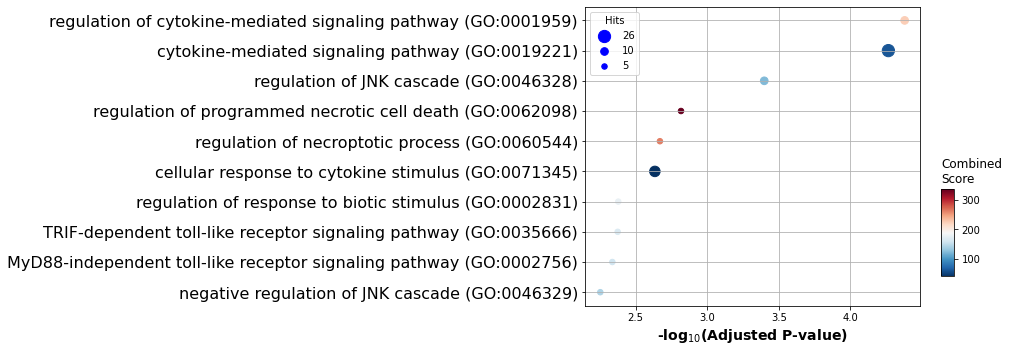

In [51]:
gseapy.dotplot(GO_cDC_down.res2d[GO_cDC_down.res2d["n_genes"]>4])

In [58]:
len(cDC_go_hits)

64

In [57]:
GO_cDC_down.res2d.to_csv("cd8a_specific_genes_enrichment/cDC_CD8a_specific_genes_down_GO.csv")
GO_cDC_up.res2d.to_csv("cd8a_specific_genes_enrichment/cDC_CD8a_specific_genes_up_GO.csv")

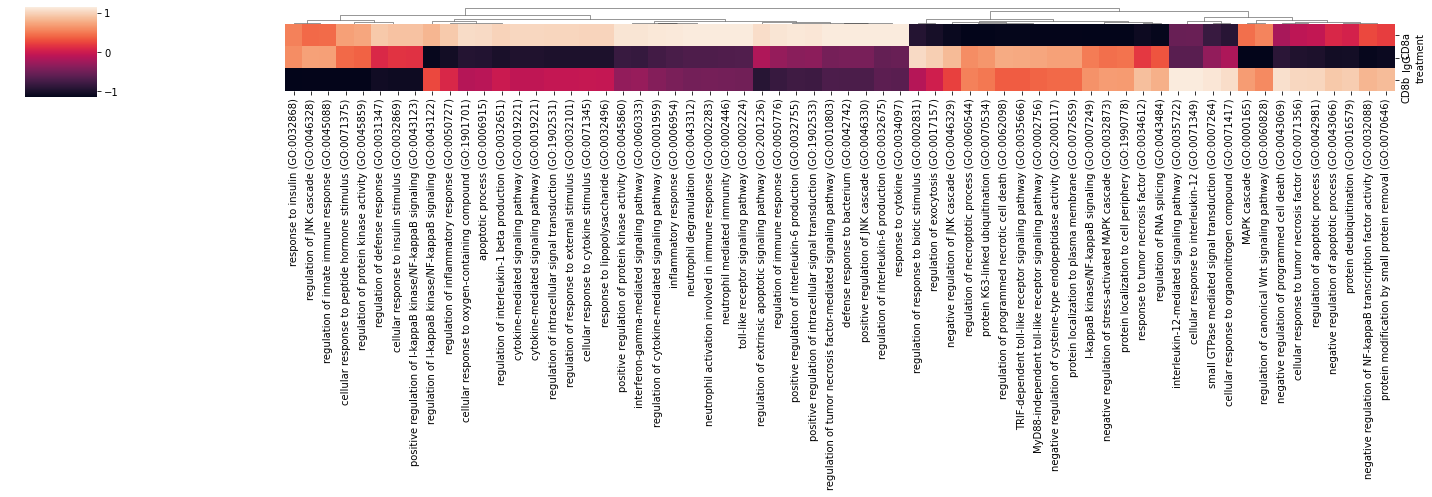

In [64]:
adata_sub = adata_nodub[adata_nodub.obs["General Celltypes"]=="cDC"]
sns.clustermap(adata_sub.obs[["treatment",]+list(cDC_go_hits)].groupby(["treatment"]).mean().loc[["CD8a","IgG","CD8b"]],figsize=(20,7),row_cluster=False,z_score=1)


IFITM3.like..1
MAFA.F
IFITM3.like..2
LD5.1
NKX2.1
Mafa.B
NKX3.1
IFITM3.like..3
ERV3.1
ERVMER34.1
IFITM3.like..1
MAFA.F
IFITM3.like..2
LD5.1
NKX2.1
Mafa.B
NKX3.1
IFITM3.like..3
ERV3.1
ERVMER34.1
['neutrophil mediated immunity (GO:0002446)'
 'neutrophil degranulation (GO:0043312)'
 'neutrophil activation involved in immune response (GO:0002283)'
 'cytokine-mediated signaling pathway (GO:0019221)'
 'interleukin-1-mediated signaling pathway (GO:0070498)']


2023-06-28 17:48:07,426 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


['negative regulation of intracellular signal transduction (GO:1902532)'
 'nuclear-transcribed mRNA catabolic process (GO:0000956)'
 'negative regulation of protein serine/threonine kinase activity (GO:0071901)'
 'nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)'
 'negative regulation of transcription by RNA polymerase II (GO:0000122)']
neutrophil mediated immunity (GO:0002446)
neutrophil degranulation (GO:0043312)
neutrophil activation involved in immune response (GO:0002283)
cytokine-mediated signaling pathway (GO:0019221)
interleukin-1-mediated signaling pathway (GO:0070498)
cellular response to interleukin-1 (GO:0071347)
positive regulation of NF-kappaB transcription factor activity (GO:0051092)
positive regulation of DNA-binding transcription factor activity (GO:0051091)
regulation of interleukin-6 production (GO:0032675)
cellular response to type I interferon (GO:0071357)
type I interferon signaling pathway (GO:0060337)
cellular response to cytokin

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


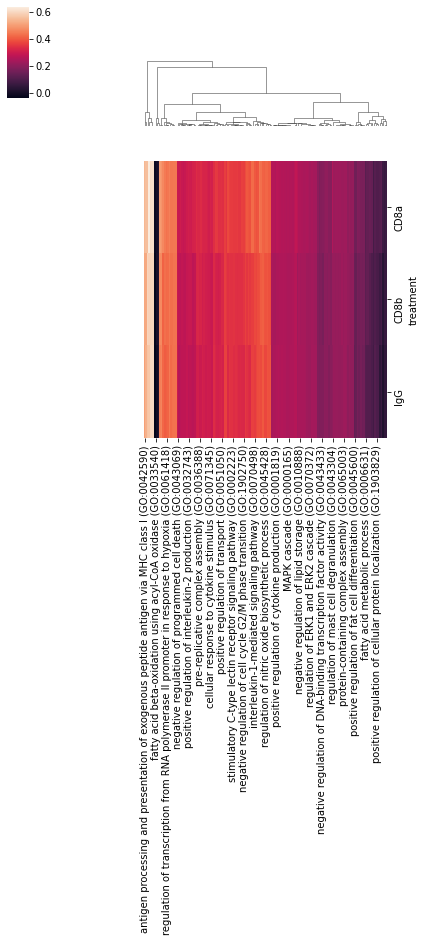

In [43]:
celltype = 'Macrophages/Monocytes'
celltype_filename = 'Macrophages_Monocytes'
moma_a_up, moma_a_down, moma_go_hits = alpha_specific_changes('Macrophages/Monocytes', 'Macrophages_Monocytes')
adata_sub = adata_nodub[adata_nodub.obs["General Celltypes"]==celltype]
adata_sub.obs[["treatment",]+list(moma_go_hits)].groupby(["treatment"]).mean().to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_mean_hits.csv")
pd.DataFrame(index=moma_a_up).to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_CD8a_specific_genes_up.txt")
pd.DataFrame(index=moma_a_down).to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_CD8a_specific_genes_down.txt")

In [22]:
moma_a_up, moma_a_down, moma_GO_up,moma_GO_down = alpha_specific_changes('Macrophages/Monocytes', 'Macrophages_Monocytes',cell_score=False)


IFITM3.like..1
Mafa.B
LD5.1
NKX3.1
ERVMER34.1
ERV3.1
IFITM3.like..3
IFITM3.like..2
NKX2.1
MAFA.F
IFITM3.like..1
Mafa.B
LD5.1
NKX3.1
ERVMER34.1
ERV3.1
IFITM3.like..3
IFITM3.like..2
NKX2.1
MAFA.F
['neutrophil mediated immunity (GO:0002446)'
 'neutrophil degranulation (GO:0043312)'
 'neutrophil activation involved in immune response (GO:0002283)'
 'cytokine-mediated signaling pathway (GO:0019221)'
 'interleukin-1-mediated signaling pathway (GO:0070498)']


2023-06-30 12:53:16,884 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


['negative regulation of intracellular signal transduction (GO:1902532)'
 'nuclear-transcribed mRNA catabolic process (GO:0000956)'
 'negative regulation of protein serine/threonine kinase activity (GO:0071901)'
 'nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)'
 'negative regulation of transcription by RNA polymerase II (GO:0000122)']


/afs/csail.mit.edu/u/n/nyquist/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

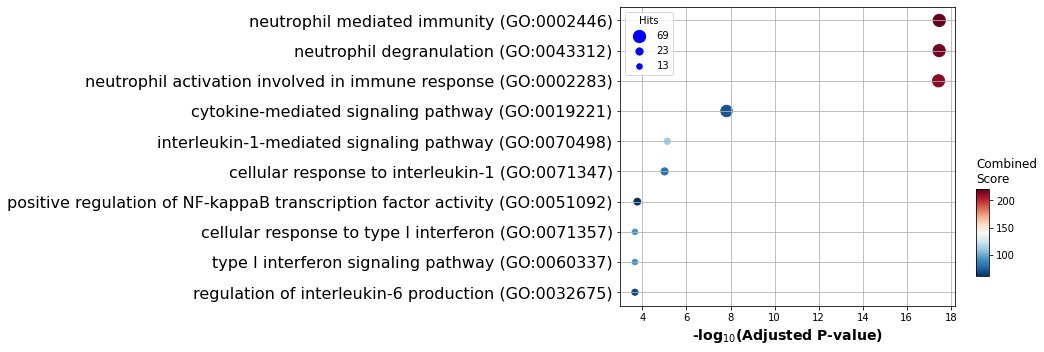

In [52]:
gseapy.dotplot(moma_GO_up.res2d[moma_GO_up.res2d["n_genes"]>4])

In [25]:
gseapy.dotplot(moma_GO_down.res2d)

'Warning: No enrich terms when cutoff = 0.05'

In [55]:
moma_GO_down.res2d.to_csv("cd8a_specific_genes_enrichment/Macrophages_Monocytes_CD8a_specific_genes_down_GO.csv")

In [56]:
moma_GO_up.res2d.to_csv("cd8a_specific_genes_enrichment/Macrophages_Monocytes_CD8a_specific_genes_up_GO.csv")

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


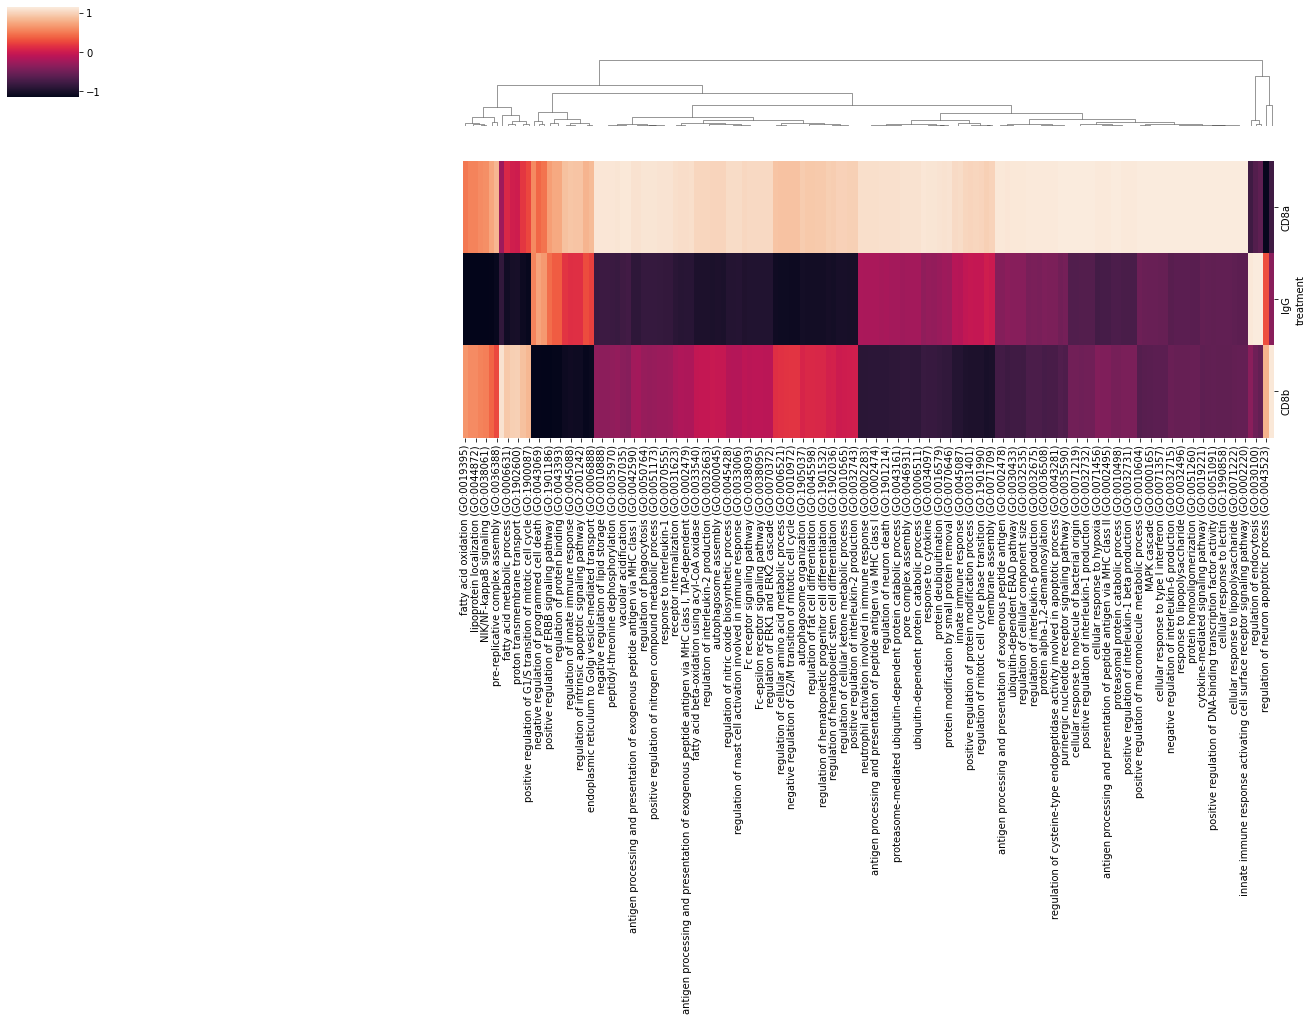

In [65]:
adata_sub = adata_nodub[adata_nodub.obs["General Celltypes"]=="Macrophages/Monocytes"]
sns.clustermap(adata_sub.obs[["treatment",]+list(moma_go_hits)].groupby(["treatment"]).mean().loc[["CD8a","IgG","CD8b"]],figsize=(20,7),row_cluster=False,z_score=1)


IFITM3.like..1
MAFA.F
IFITM3.like..2
LD5.1
NKX2.1
Mafa.B
NKX3.1
IFITM3.like..3
ERV3.1
ERVMER34.1
IFITM3.like..1
MAFA.F
IFITM3.like..2
LD5.1
NKX2.1
Mafa.B
NKX3.1
IFITM3.like..3
ERV3.1
ERVMER34.1
['antigen processing and presentation of exogenous peptide antigen via MHC class I (GO:0042590)'
 'antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-dependent (GO:0002479)'
 'proteasomal ubiquitin-independent protein catabolic process (GO:0010499)'
 'regulation of hematopoietic stem cell differentiation (GO:1902036)'
 'regulation of hematopoietic progenitor cell differentiation (GO:1901532)']


2023-06-28 17:49:24,838 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


['regulation of B cell activation (GO:0050864)'
 'response to chemokine (GO:1990868)'
 'peptidyl-serine phosphorylation (GO:0018105)'
 'regulation of cell differentiation (GO:0045595)'
 'negative regulation of transcription, DNA-templated (GO:0045892)']
antigen processing and presentation of exogenous peptide antigen via MHC class I (GO:0042590)
antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-dependent (GO:0002479)
proteasomal ubiquitin-independent protein catabolic process (GO:0010499)


regulation of hematopoietic stem cell differentiation (GO:1902036)
regulation of hematopoietic progenitor cell differentiation (GO:1901532)
regulation of transcription from RNA polymerase II promoter in response to hypoxia (GO:0061418)
regulation of cellular amine metabolic process (GO:0033238)
regulation of cellular amino acid metabolic process (GO:0006521)
Wnt signaling pathway, planar cell polarity pathway (GO:0060071)
negative regulation of cell cycle G2/M phase transition (GO:1902750)
regulation of transcription from RNA polymerase II promoter in response to stress (GO:0043618)
regulation of establishment of planar polarity (GO:0090175)
non-canonical Wnt signaling pathway (GO:0035567)
regulation of stem cell differentiation (GO:2000736)


regulation of cellular ketone metabolic process (GO:0010565)
pre-replicative complex assembly (GO:0036388)
negative regulation of G2/M transition of mitotic cell cycle (GO:0010972)
NIK/NF-kappaB signaling (GO:0038061)
anaphase-promoting complex-dependent catabolic process (GO:0031145)
SCF-dependent proteasomal ubiquitin-dependent protein catabolic process (GO:0031146)


antigen processing and presentation of peptide antigen via MHC class I (GO:0002474)
positive regulation of canonical Wnt signaling pathway (GO:0090263)


negative regulation of mitotic cell cycle phase transition (GO:1901991)


cellular response to hypoxia (GO:0071456)
interleukin-1-mediated signaling pathway (GO:0070498)
regulation of cell cycle phase transition (GO:1901987)


post-translational protein modification (GO:0043687)


neutrophil degranulation (GO:0043312)
neutrophil activation involved in immune response (GO:0002283)
neutrophil mediated immunity (GO:0002446)
positive regulation of Wnt signaling pathway (GO:0030177)


Fc-epsilon receptor signaling pathway (GO:0038095)
Fc receptor signaling pathway (GO:0038093)
T cell receptor signaling pathway (GO:0050852)
cellular response to lectin (GO:1990858)
stimulatory C-type lectin receptor signaling pathway (GO:0002223)
tumor necrosis factor-mediated signaling pathway (GO:0033209)
negative regulation of canonical Wnt signaling pathway (GO:0090090)


innate immune response activating cell surface receptor signaling pathway (GO:0002220)
regulation of mRNA catabolic process (GO:0061013)
DNA-dependent DNA replication (GO:0006261)


regulation of primary metabolic process (GO:0080090)
positive regulation of peptidyl-tyrosine phosphorylation (GO:0050731)


antigen receptor-mediated signaling pathway (GO:0050851)


negative regulation of Wnt signaling pathway (GO:0030178)


cellular response to tumor necrosis factor (GO:0071356)
protein-DNA complex assembly (GO:0065004)


regulation of mRNA stability (GO:0043488)
regulation of G2/M transition of mitotic cell cycle (GO:0010389)


cytokine-mediated signaling pathway (GO:0019221)
cellular response to interleukin-1 (GO:0071347)
cellular protein modification process (GO:0006464)
regulation of mitotic cell cycle (GO:0007346)


peptide metabolic process (GO:0006518)


regulation of mitotic cell cycle phase transition (GO:1901990)
regulation of canonical Wnt signaling pathway (GO:0060828)
protein deubiquitination (GO:0016579)
proteasomal protein catabolic process (GO:0010498)
ubiquitin-dependent protein catabolic process (GO:0006511)
MAPK cascade (GO:0000165)
protein polyubiquitination (GO:0000209)
proteasome-mediated ubiquitin-dependent protein catabolic process (GO:0043161)
cellular protein metabolic process (GO:0044267)
positive regulation of cell migration (GO:0030335)
protein modification by small protein removal (GO:0070646)
response to cytokine (GO:0034097)


/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


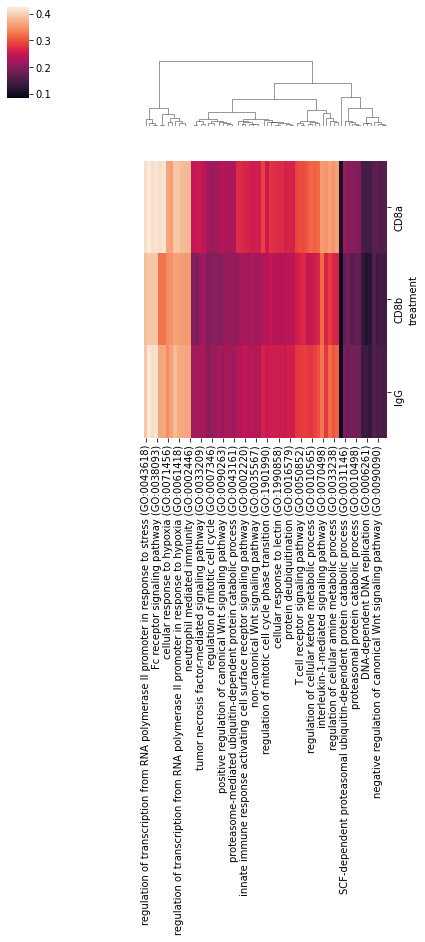

In [44]:

mast_a_up, mast_a_down, mast_go_hits = alpha_specific_changes('Mast', 'Mast')
celltype = "Mast"
celltype_filename = "Mast"
adata_sub = adata_nodub[adata_nodub.obs["General Celltypes"]==celltype]
adata_sub.obs[["treatment",]+list(mast_go_hits)].groupby(["treatment"]).mean().to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_mean_hits.csv")
pd.DataFrame(index=mast_a_up).to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_CD8a_specific_genes_up.txt")
pd.DataFrame(index=mast_a_down).to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_CD8a_specific_genes_down.txt")

In [56]:
len(mast_go_hits)

66

In [42]:
mast_a_up, mast_a_down, mast_go_up,mast_go_down = alpha_specific_changes('Mast', 'Mast',cell_score=False)

IFITM3.like..1
Mafa.B
LD5.1
NKX3.1
ERVMER34.1
ERV3.1
IFITM3.like..3
IFITM3.like..2
NKX2.1
MAFA.F
IFITM3.like..1
Mafa.B
LD5.1
NKX3.1
ERVMER34.1
ERV3.1
IFITM3.like..3
IFITM3.like..2
NKX2.1
MAFA.F
['antigen processing and presentation of exogenous peptide antigen via MHC class I (GO:0042590)'
 'antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-dependent (GO:0002479)'
 'proteasomal ubiquitin-independent protein catabolic process (GO:0010499)'
 'regulation of hematopoietic stem cell differentiation (GO:1902036)'
 'regulation of hematopoietic progenitor cell differentiation (GO:1901532)']


2023-06-30 13:12:30,244 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


['regulation of B cell activation (GO:0050864)'
 'response to chemokine (GO:1990868)'
 'peptidyl-serine phosphorylation (GO:0018105)'
 'regulation of cell differentiation (GO:0045595)'
 'negative regulation of transcription, DNA-templated (GO:0045892)']


/afs/csail.mit.edu/u/n/nyquist/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:xlabel='-log$_{10}$(Adjusted P-value)'>

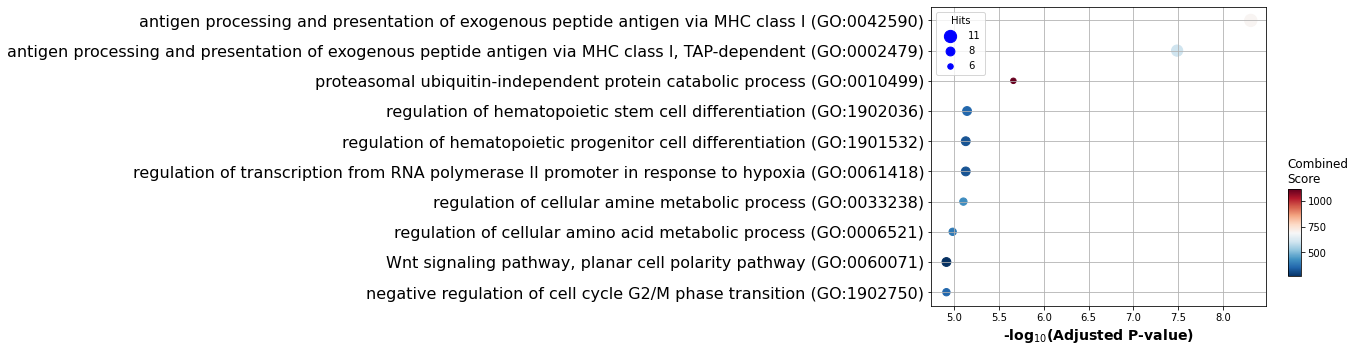

In [53]:
gseapy.dotplot(mast_go_up.res2d[mast_go_up.res2d["n_genes"]>4])

In [54]:
mast_go_up.res2d.to_csv("cd8a_specific_genes_enrichment/Mast_CD8a_specific_genes_up_GO.csv")

In [44]:
gseapy.dotplot(mast_go_down.res2d)

'Warning: No enrich terms when cutoff = 0.05'

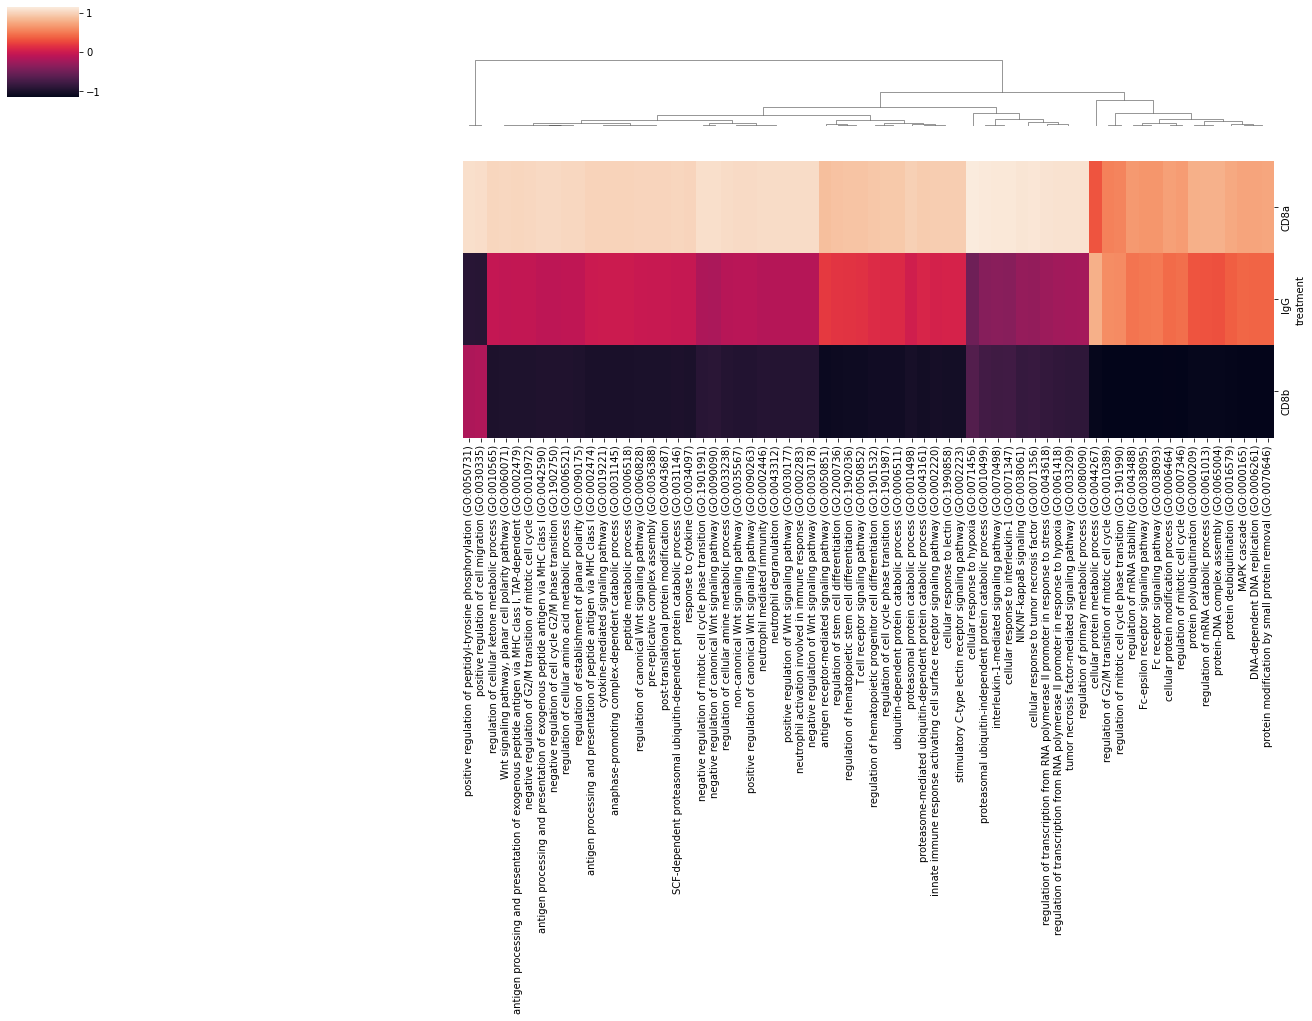

In [66]:
adata_sub = adata_nodub[adata_nodub.obs["General Celltypes"]=="Mast"]
sns.clustermap(adata_sub.obs[["treatment",]+list(mast_go_hits)].groupby(["treatment"]).mean().loc[["CD8a","IgG","CD8b"]],figsize=(20,7),row_cluster=False,z_score=1)


IFITM3.like..1
MAFA.F
IFITM3.like..2
LD5.1
NKX2.1
Mafa.B
NKX3.1
IFITM3.like..3
ERV3.1
ERVMER34.1
IFITM3.like..1
MAFA.F
IFITM3.like..2
LD5.1
NKX2.1
Mafa.B
NKX3.1
IFITM3.like..3
ERV3.1
ERVMER34.1
['neutrophil degranulation (GO:0043312)'
 'proteasomal ubiquitin-independent protein catabolic process (GO:0010499)'
 'neutrophil activation involved in immune response (GO:0002283)'
 'neutrophil mediated immunity (GO:0002446)'
 'regulation of substrate adhesion-dependent cell spreading (GO:1900024)']


['protein targeting to ER (GO:0045047)'
 'cotranslational protein targeting to membrane (GO:0006613)'
 'SRP-dependent cotranslational protein targeting to membrane (GO:0006614)'
 'nuclear-transcribed mRNA catabolic process (GO:0000956)'
 'cytoplasmic translation (GO:0002181)']
neutrophil degranulation (GO:0043312)
neutrophil activation involved in immune response (GO:0002283)
neutrophil mediated immunity (GO:0002446)
regulation of substrate adhesion-dependent cell spreading (GO:1900024)


RNA splicing, via transesterification reactions with bulged adenosine as nucleophile (GO:0000377)


regulation of G2/M transition of mitotic cell cycle (GO:0010389)
NIK/NF-kappaB signaling (GO:0038061)
mRNA splicing, via spliceosome (GO:0000398)


Wnt signaling pathway, planar cell polarity pathway (GO:0060071)
mRNA processing (GO:0006397)


regulation of establishment of planar polarity (GO:0090175)
negative regulation of mitotic cell cycle phase transition (GO:1901991)
protein localization to cell periphery (GO:1990778)
protein localization to membrane (GO:0072657)


interleukin-1-mediated signaling pathway (GO:0070498)
regulation of signal transduction (GO:0009966)


mRNA-containing ribonucleoprotein complex export from nucleus (GO:0071427)


actin filament organization (GO:0007015)


mRNA transport (GO:0051028)


RNA export from nucleus (GO:0006405)


mRNA export from nucleus (GO:0006406)


protein targeting to ER (GO:0045047)


cotranslational protein targeting to membrane (GO:0006613)


SRP-dependent cotranslational protein targeting to membrane (GO:0006614)


nuclear-transcribed mRNA catabolic process (GO:0000956)


cytoplasmic translation (GO:0002181)


nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)


translation (GO:0006412)


peptide biosynthetic process (GO:0043043)


cellular macromolecule biosynthetic process (GO:0034645)


gene expression (GO:0010467)


rRNA processing (GO:0006364)


rRNA metabolic process (GO:0016072)


ribosome biogenesis (GO:0042254)


cellular protein metabolic process (GO:0044267)
ncRNA processing (GO:0034470)


ribonucleoprotein complex assembly (GO:0022618)


regulation of transcription by RNA polymerase II (GO:0006357)


ribonucleoprotein complex biogenesis (GO:0022613)


regulation of T cell differentiation (GO:0045580)


positive regulation of transcription by RNA polymerase II (GO:0045944)


regulation of gene expression (GO:0010468)


positive regulation of mRNA catabolic process (GO:0061014)


regulation of signal transduction by p53 class mediator (GO:1901796)


peptidyl-serine phosphorylation (GO:0018105)


histone H4 acetylation (GO:0043967)


peptidyl-serine modification (GO:0018209)


positive regulation of transcription, DNA-templated (GO:0045893)


regulation of RNA splicing (GO:0043484)
negative regulation of transcription by RNA polymerase II (GO:0000122)


regulation of cellular response to heat (GO:1900034)


/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


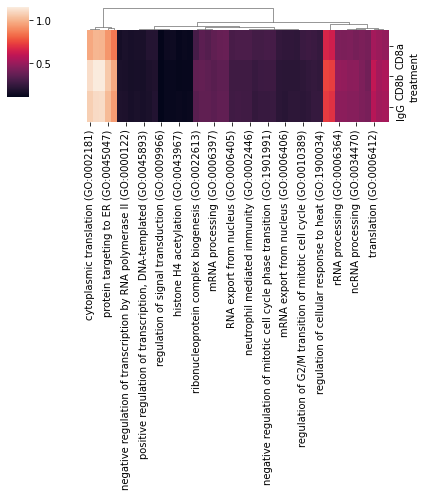

In [45]:
t_a_up, t_a_down, t_go_hits = alpha_specific_changes('T/NK', 'T_NK')
celltype = "T/NK"
celltype_filename = "T_NK"
adata_sub = adata_nodub[adata_nodub.obs["General Celltypes"]==celltype]
adata_sub.obs[["treatment",]+list(t_go_hits)].groupby(["treatment"]).mean().to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_mean_hits.csv")
pd.DataFrame(index=t_a_up).to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_CD8a_specific_genes_up.txt")
pd.DataFrame(index=t_a_down).to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_CD8a_specific_genes_down.txt")

In [55]:
len(t_go_hits)

51

In [51]:
b_a_up, b_a_down, b_go_hits = alpha_specific_changes('B Cells', 'B Cells')
celltype = "B Cells"
celltype_filename = "B Cells"
adata_sub = adata_nodub[adata_nodub.obs["General Celltypes"]==celltype]
#adata_sub.obs[["treatment",]+list(b_go_hits)].groupby(["treatment"]).mean().to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_mean_hits.csv")
pd.DataFrame(index=b_a_up).to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_CD8a_specific_genes_up.txt")
pd.DataFrame(index=b_a_down).to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_CD8a_specific_genes_down.txt")

IFITM3.like..1
MAFA.F
IFITM3.like..2
LD5.1
NKX2.1
Mafa.B
NKX3.1
IFITM3.like..3
ERV3.1
ERVMER34.1
IFITM3.like..1
MAFA.F
IFITM3.like..2
LD5.1
NKX2.1
Mafa.B
NKX3.1
IFITM3.like..3
ERV3.1
ERVMER34.1
['positive regulation of response to endoplasmic reticulum stress (GO:1905898)'
 'negative regulation of membrane potential (GO:0045837)'
 'regulation of dendritic cell antigen processing and presentation (GO:0002604)'
 'negative regulation of production of molecular mediator of immune response (GO:0002701)'
 'N-acylphosphatidylethanolamine metabolic process (GO:0070292)']


2023-06-28 18:06:08,769 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


['SRP-dependent cotranslational protein targeting to membrane (GO:0006614)'
 'nuclear-transcribed mRNA catabolic process (GO:0000956)'
 'glomerular visceral epithelial cell differentiation (GO:0072112)'
 'rRNA processing (GO:0006364)' 'cell junction maintenance (GO:0034331)']
0


In [54]:
pDC_a_up, pDC_a_down, pDC_go_hits = alpha_specific_changes('pDC', 'pDC')
celltype = "pDC"
celltype_filename = "pDC"
adata_sub = adata_nodub[adata_nodub.obs["General Celltypes"]==celltype]
#adata_sub.obs[["treatment",]+list(pDC_go_hits)].groupby(["treatment"]).mean().to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_mean_hits.csv")
pd.DataFrame(index=pDC_a_up).to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_CD8a_specific_genes_up.txt")
pd.DataFrame(index=pDC_a_down).to_csv("cd8a_specific_genes_enrichment/"+celltype_filename+"_CD8a_specific_genes_down.txt")

IFITM3.like..1
MAFA.F
IFITM3.like..2
LD5.1
NKX2.1
Mafa.B
NKX3.1
IFITM3.like..3
ERV3.1
ERVMER34.1
IFITM3.like..1
MAFA.F
IFITM3.like..2
LD5.1
NKX2.1
Mafa.B
NKX3.1
IFITM3.like..3
ERV3.1
ERVMER34.1
['cellular protein catabolic process (GO:0044257)'
 'proteolysis involved in cellular protein catabolic process (GO:0051603)'
 'positive regulation of brown fat cell differentiation (GO:0090336)'
 'activation of cysteine-type endopeptidase activity (GO:0097202)'
 'positive regulation of alpha-beta T cell differentiation (GO:0046638)']
['SRP-dependent cotranslational protein targeting to membrane (GO:0006614)'
 'cytoplasmic translation (GO:0002181)'
 'cotranslational protein targeting to membrane (GO:0006613)'
 'protein targeting to ER (GO:0045047)'
 'nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)']
0


/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [32]:
adata_sub.obs[["treatment",]+list(hits)].groupby(["treatment"]).mean()

,neutrophil degranulation (GO:0043312),neutrophil activation involved in immune response (GO:0002283),neutrophil mediated immunity (GO:0002446),cytokine-mediated signaling pathway (GO:0019221),regulation of interleukin-6 production (GO:0032675),positive regulation of interleukin-6 production (GO:0032755),defense response to bacterium (GO:0042742),regulation of interleukin-1 beta production (GO:0032651),toll-like receptor signaling pathway (GO:0002224)
treatment,,,,,,,,,
CD8a,0.455126,0.456030,0.451755,0.321623,0.272688,0.281780,0.138342,0.214272,0.316190
CD8b,0.426118,0.427475,0.423007,0.314069,0.243714,0.243506,0.118950,0.203922,0.291602
IgG,0.422361,0.423645,0.419525,0.307942,0.244380,0.251968,0.121522,0.193691,0.288875


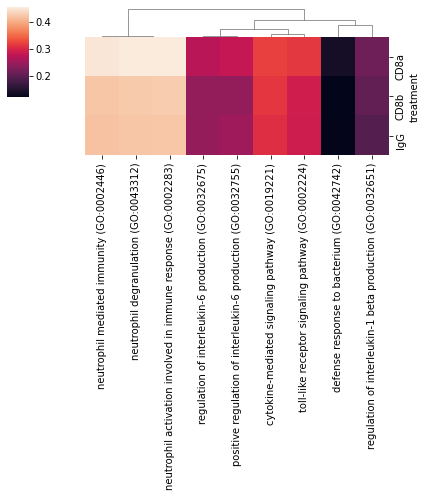

In [33]:
sns.clustermap(adata_sub.obs[["treatment",]+list(hits)].groupby(["treatment"]).mean(),figsize=(6,7),row_cluster=False)
